# <span style="color:Tomato">AUTOMATIC TICKET CLASSIFICATION - CASE STUDY</span>

# <span style="color:DodgerBlue">Problem Statement</span>

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

**Credit card / Prepaid card**

**Bank account services**

**Theft/Dispute reporting**

**Mortgages/loans**

**Others**

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

# <span style="color:Violet">Problem Solving Approach (Pipeline)</span>

### Table of Content 

**1. Data loading/reading**

**2. Data cleaning**

**3. Text preprocessing**

**4. Exploratory data analysis (EDA)**

**5. Feature extraction**

**6. Topic modelling**

**7. Model building with the help of supervised learning**

**8. Model training & evaluation**

**9. Model inference**

## <span style="color:Orange">Import and Install useful packages</span>

In [1]:
!python -m pip install --upgrade pip

In [2]:
!pip install textblob
!pip install wordcloud
!pip install catboost
!pip install pycrf
!pip install sklearn-crfsuite
!pip install gensim

# Libraries require for data reading & data visualization 
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns


# Libraries loadings for EDA
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Libraries loading for input text preprocessing
import re, nltk, spacy, string
nlp = spacy.load("en_core_web_sm")

# from scikit-learn and NLP libraries 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF



# Libraries for machine to learns models
import nltk
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RGhogare\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# suppress warnings 

import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Task 1: Input Data reading and understanding </span>

In [4]:
# Loading the json format data and reading into Pandas dataframe 

atc = open('complaints.json',)
  

data = json.load(atc) # Get the JSON object into dictionary format

df_atc = pd.json_normalize(data) # convert dictionary to  a dataframe 

In [5]:
# view the dataframe
df_atc.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
# shape of dataframe
df_atc.shape

(78313, 22)

In [7]:
df_atc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
df_atc.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


**_score is the only numeric columns with all values zeroes**

In [9]:
# get the column names

columns_name = list(df_atc.columns)
columns_name

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

### Inspect missing data % in different columns

In [10]:
round(100*df_atc.isna().sum()/len(df_atc),2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened       0.00
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

**The customer complaint column is in "_source.complaint_what_happened" and there are no missing data**

## <span style="color:Orange">Task 2: Data Cleaning : Raw Text Data </span>

**Rename the column as these are changed due to normalization and also clean leading underscore in column name**

In [11]:
# Removing leading leading "_" from column names using regex
df_atc.columns=[re.sub('^_','',col) for col in df_atc.columns]


list(df_atc.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

**Also remove leading source name**

In [12]:
df_atc.columns=[re.sub(r"^\bsource\b\.","",col) for col in df_atc.columns]
list(df_atc.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [13]:
# view data set

df_atc.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
# shape of datframe
df_atc.shape

(78313, 22)

In [15]:
df_atc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

As we can see above : the main column which we are interested in  <span style="color:#9400D3">"complaint_what_happened" </span> has missing string and which Pandas doesn't recognise as null. "Pandas dataframe will recognise a value as null if it is a np.nan object, which will print as NaN in the DataFrame. To fix this, we are going to convert the empty stings (or whatever is in your empty cells) to np.nan objects using replace(), and then call dropna()on your DataFrame to delete rows with null tenants

In [16]:
df_atc['complaint_what_happened'].replace('', np.nan, inplace=True)

In [17]:
df_atc.dropna(subset=['complaint_what_happened'], inplace=True)

In [18]:
df_atc.shape

(21072, 22)

**In total, there are 21,072 rows with data for complaint_what_happened features** 

## <span style="color:Orange">Task 3: Text(Data) preprocessing </span>

**Preparing data for topic modelling**

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [19]:
df_atc['complaint_what_happened'].head(2)

1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
Name: complaint_what_happened, dtype: object

#### Creating a function to clean the input data

In [20]:
def text_process(inputtext):
    '''
    function to create the 
    text for topic modelling 
    '''
        
    inputtext=inputtext.lower() #Make the text lowercase
    
    
    inputtext=re.sub(r'\[.*?\]','',inputtext) #eliminate text in square brackets
    
    
    inputtext=re.sub(r'[%s]%re.escape(string.punctuation)','',inputtext) #Remove punctuation
    
    
    inputtext = re.sub(r'\w*\d\w*', '', inputtext) # eliminate words containing numbers
    
    return inputtext

In [21]:
# Applying "text_process" on feature columns 
df_process = pd.DataFrame(df_atc['complaint_what_happened'].apply(lambda x: text_process(x)))

In [22]:
df_process.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,"chase card was reported on xx/xx/. however, fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...


#### Follow the similar procedure for Lemmatize the texts and extracting Pos tags

In [23]:
def lemma_data(data):
    
    '''
     function to lemmatize texts 
    
    '''   
    
    store_lemms = [] # create empty list to store lemmas
    
    # Extract lemmas of given text and add to the list 'sent'
    document_text = nlp(data)
    for word in document_text:
        store_lemms.append(word.lemma_)
        
    
    return " ".join(store_lemms)  # return joint list of lemmas

In [24]:
df_process["complaint_lemmatize"] =  df_process.apply(lambda x: lemma_data(x['complaint_what_happened']), axis=1)

# Check the dataframe
df_process.head()

,complaint_what_happened,complaint_lemmatize
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


#### As we can see from dataframe it contains -PRON- as the pos tag of any pronoun and we can extract the only singular nouns to find topics

In [25]:
# Extract singular nouns
def extract_noun_singular(data):
    """
    This function is used to extracts 
    the POS tags in relation to 
    singular noun
    """
    
    
    blob = TextBlob(data) # Generate a textblob object
    
    
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])  # Fetch words with 'NN' tags, then join  and finally return



In [26]:
# Apply the function to get singular noun

df_process["POS_removed_complaint"] =  df_process.apply(lambda x: extract_noun_singular(x['complaint_lemmatize']), axis=1)

df_process.head()  # Dataframe

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


In [27]:
df_process.head()  # Dataframe

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book xxxx ticket offer ticket card informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


## <span style="color:Orange">Task 4: Exploratory data analysis (EDA) </span>

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length'
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

In [28]:
# Get the list of lengths complaints from POS_removed_complaint feature column 
length_doc = [len(i) for i in df_process['POS_removed_complaint']]
length_doc[:15]

[159, 101, 67, 414, 155, 7, 644, 582, 1172, 51, 27, 206, 126, 138, 630]

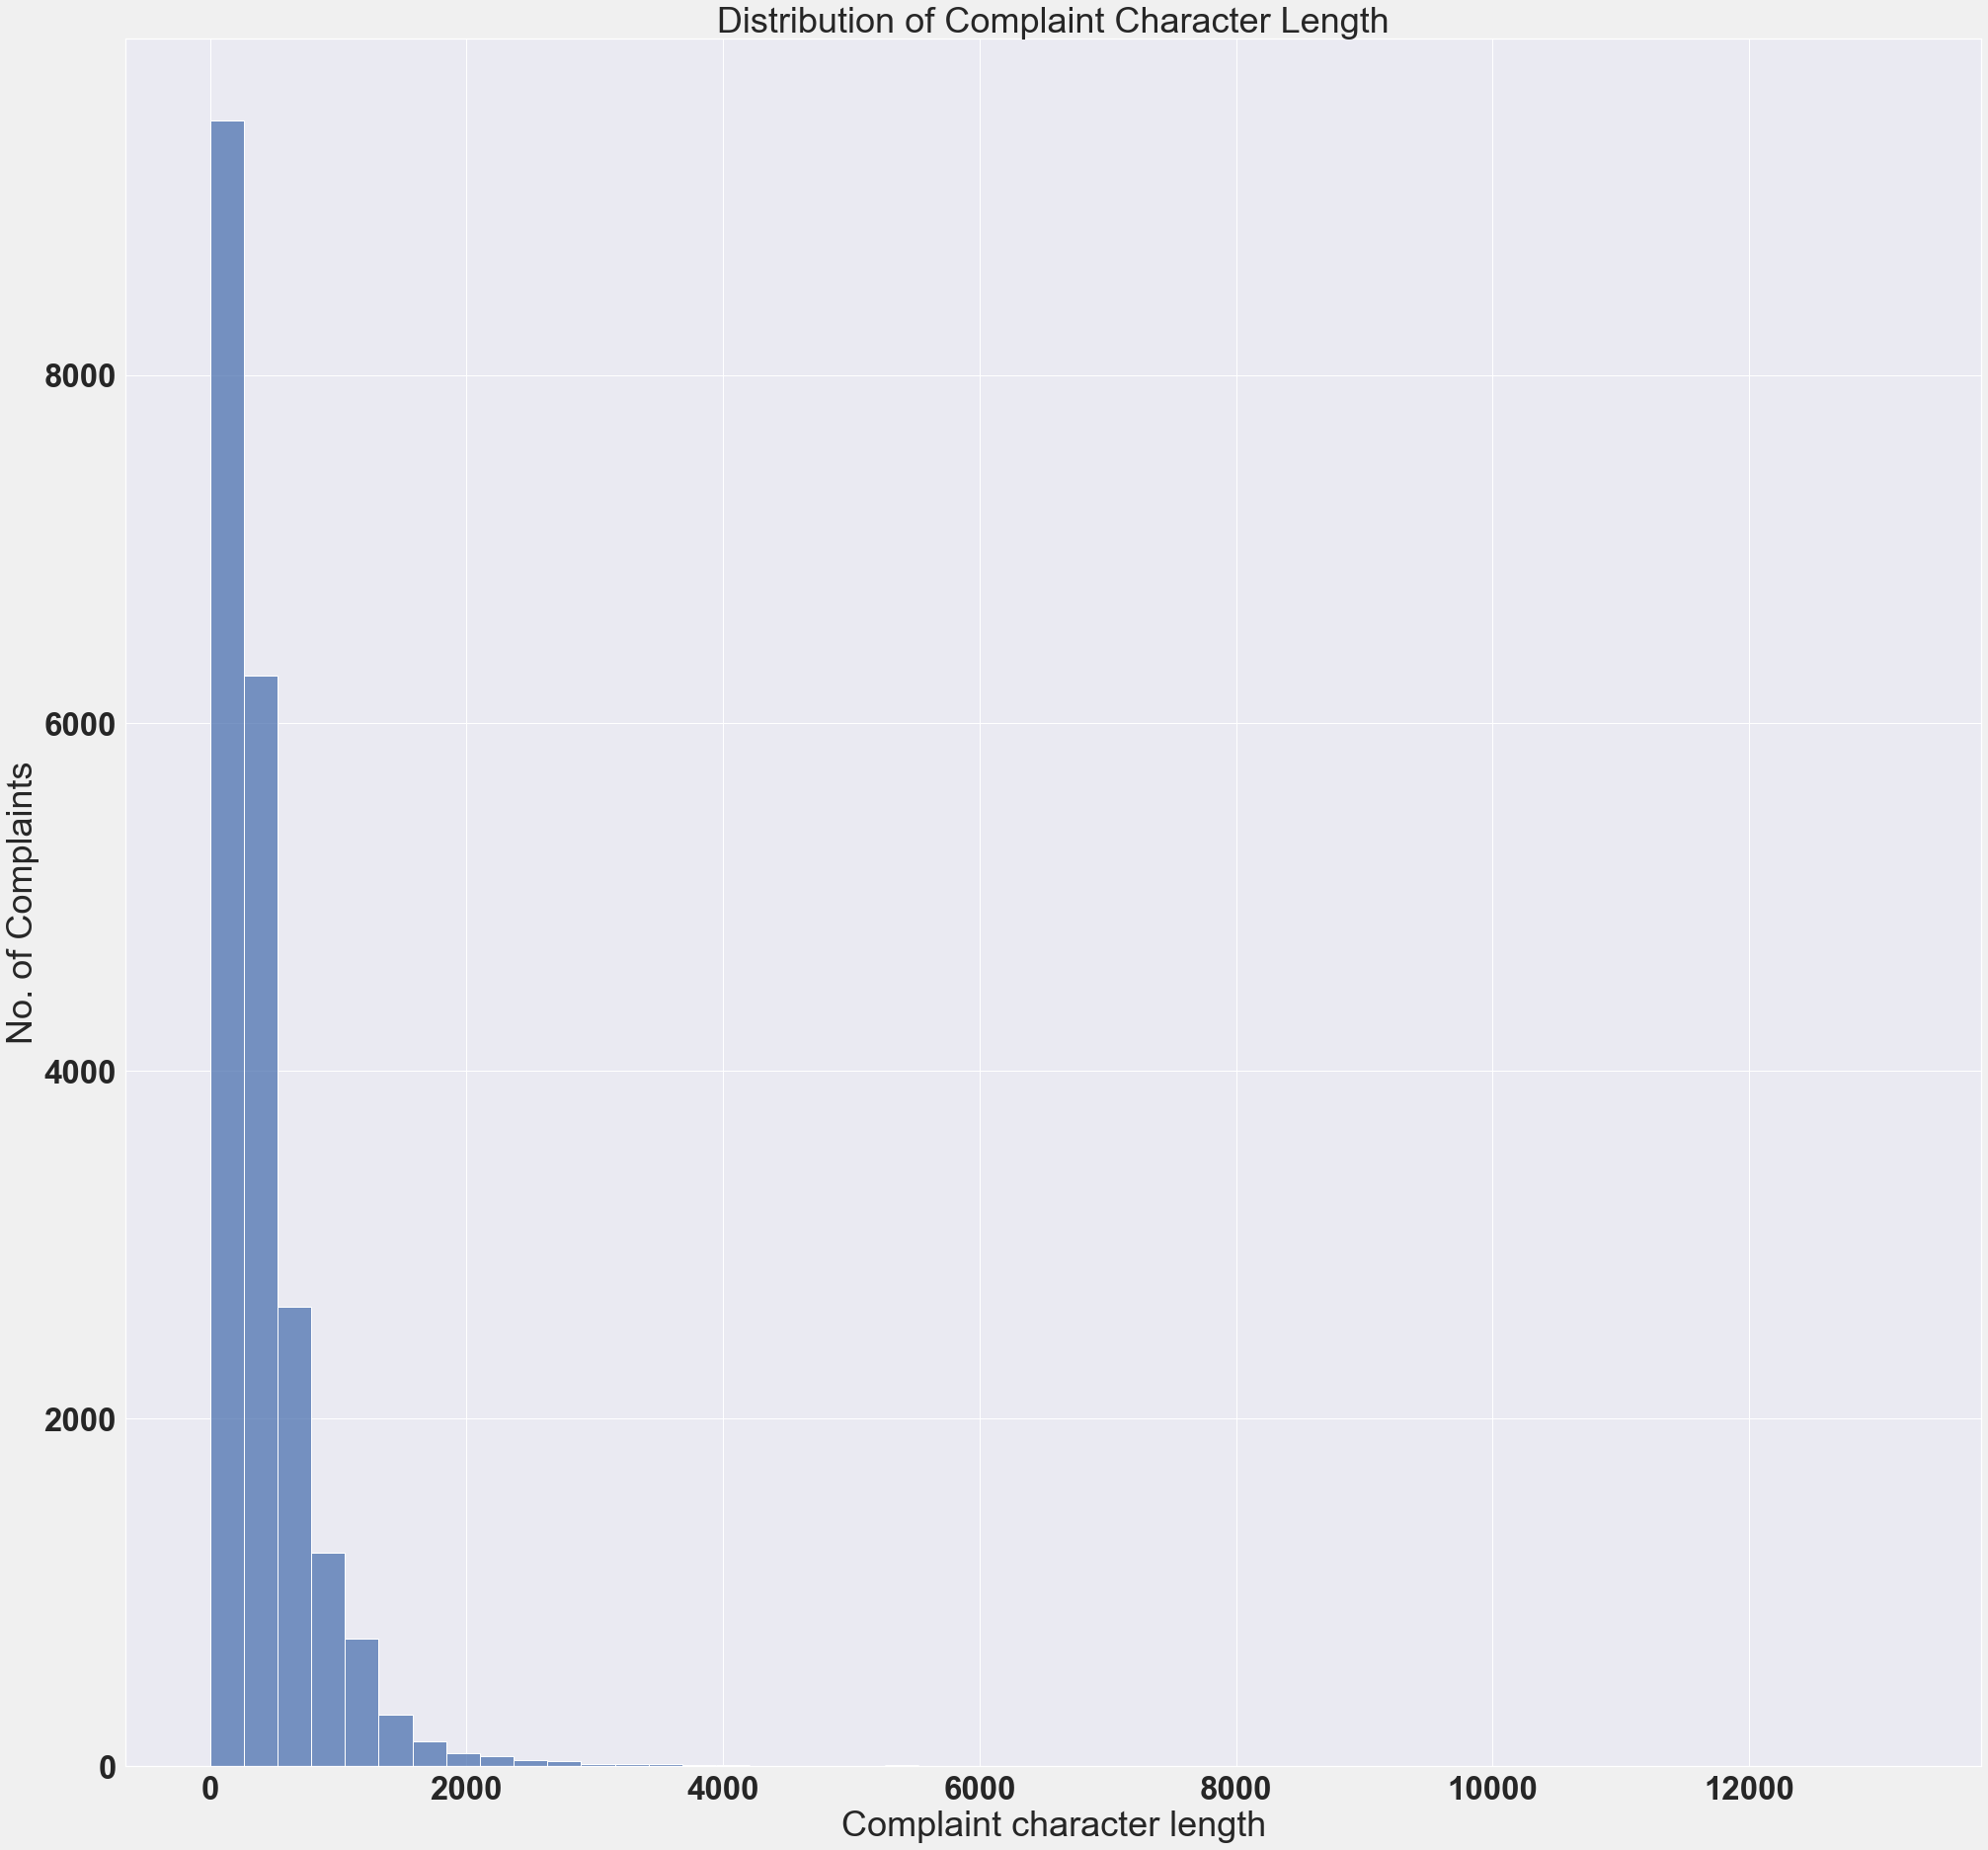

In [29]:
## Visualize the data 
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
plt.rc('font', **font)
sns.set_style("whitegrid")
sns.set(font_scale = 3)

sns.histplot(length_doc,bins=50)
plt.title('Distribution of Complaint Character Length')
plt.ylabel('No. of Complaints')
plt.xlabel('Complaint character length')
plt.show()

#### above distribution is right skewed. 

**Now we find the top 40 words by frequency among all the articles**

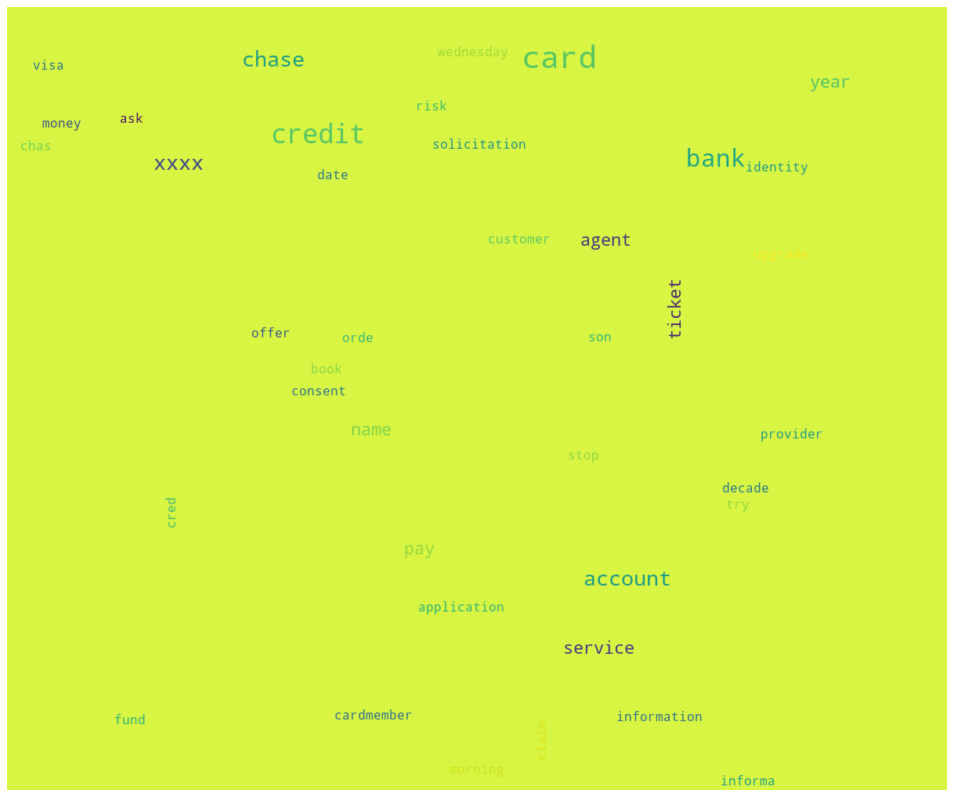

In [30]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='#d7f542',
                          stopwords=stopwords,
                          width=1200, height=1000,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_process['POS_removed_complaint']))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
#Eliminate -PRON- from the POS_removed_complaint
df_process['POS_removed_complaint'] = df_process['POS_removed_complaint'].str.replace('-PRON-', '')

In [32]:
df_process.shape

(21072, 3)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

In [33]:
def fetch_top_n_unigram(data, n=None):
    '''
    Input to this function is a corpus of words and then it return returns the top n words(unigrams) 
    as per their occurances
    data : cleaned input data
    n: number of top words(unigrams) 
    '''

    vector = CountVectorizer(stop_words='english').fit(data)
    bag_of_words = vector.transform(data)
    summation_of_words = bag_of_words.sum(axis=0) 
    word_frequency = [(word, summation_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [34]:
#Get the top 30 words in the unigram 
high_common_words = fetch_top_n_unigram(df_process['POS_removed_complaint'].values.astype('U'),30)
df_process_unigram = pd.DataFrame(high_common_words, columns = ['unigram' , 'count'])
df_process_unigram.head(10)

,unigram,count
0,chase,49232
1,account,47874
2,xxxx,43378
3,credit,34276
4,card,29640
5,bank,28513
6,payment,21338
7,time,16309
8,charge,15143
9,day,13067


#### Visualize the top unigrams 

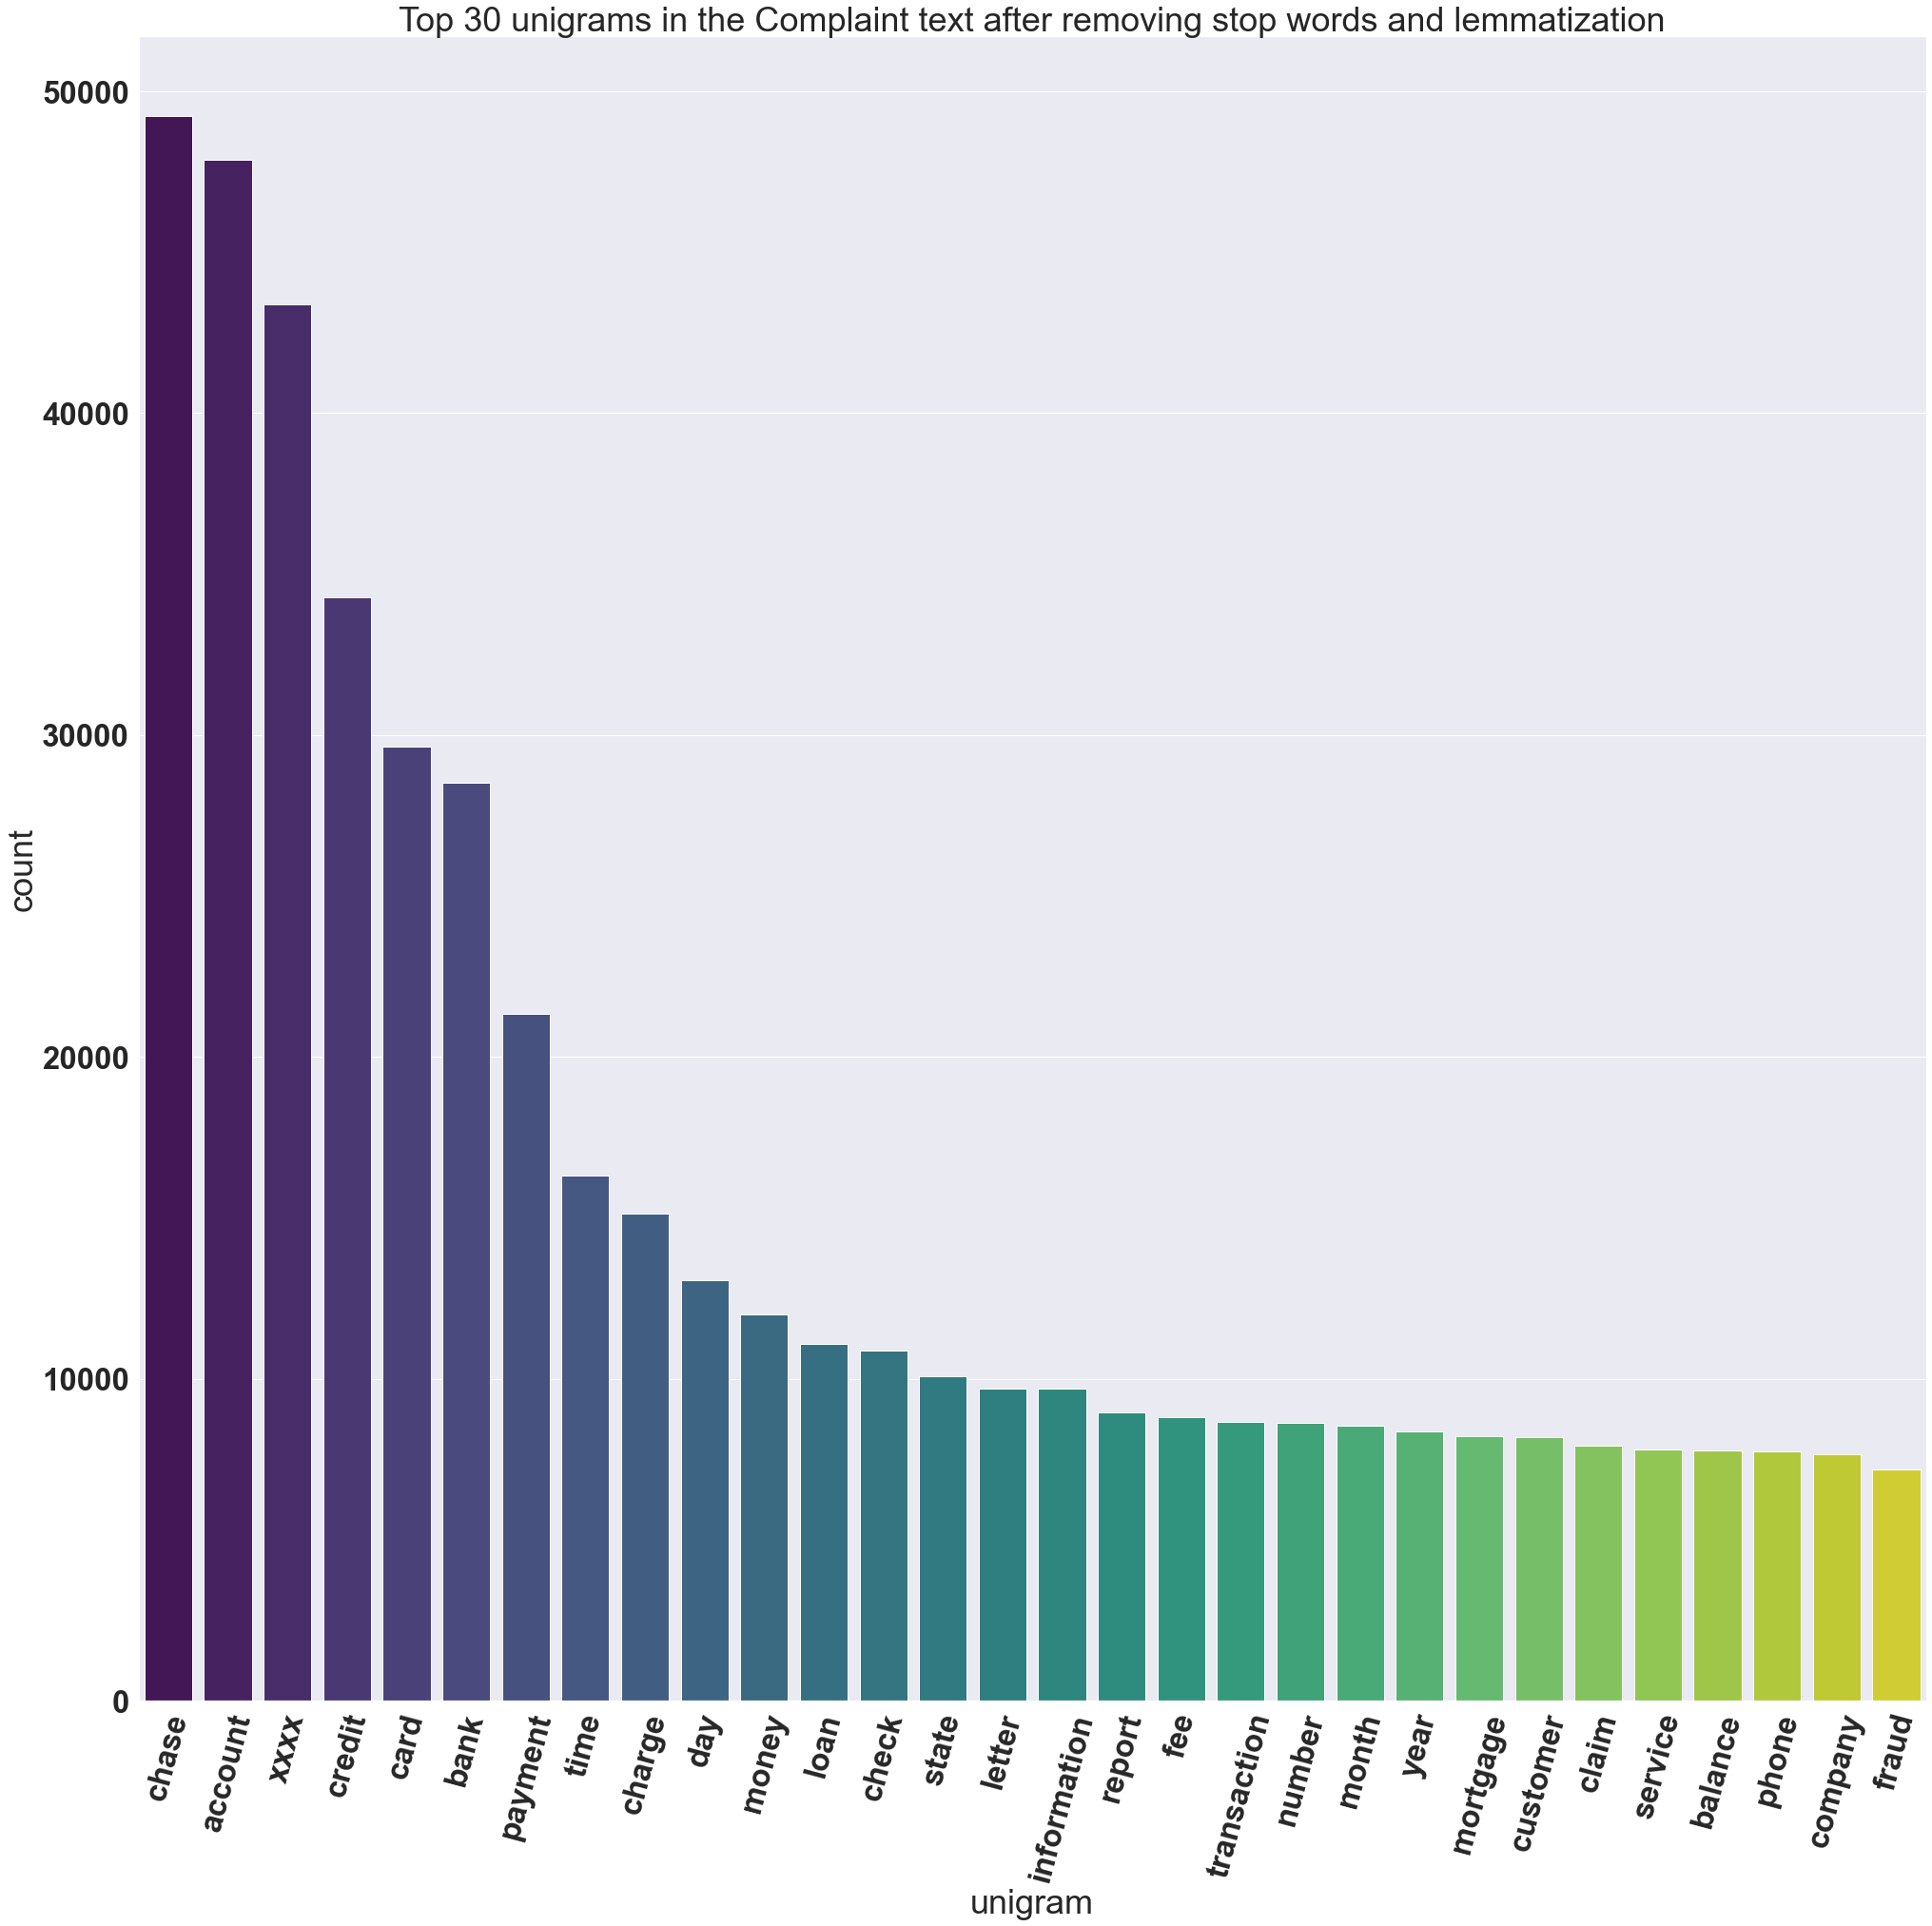

In [35]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
plt.rc('font', **font)
sns.set_style("whitegrid")
sns.set(font_scale = 3)

sns.barplot(x='unigram', y='count',data=df_process_unigram, palette="viridis" )
plt.title('Top 30 unigrams in the Complaint text after removing stop words and lemmatization')
plt.ylabel('count')
plt.xlabel('unigram')
plt.xticks(rotation=75)
plt.show()

#### Similar to unigrams find the top 30 bigrams

In [36]:
def fetch_top_n_bigram(corpus, n=None):
    '''
    Input to this function is a corpus of words and then it return returns the top n words(bigrams) 
    as per their occurances number of times
    data : cleaned input data
    n: number of top words(bigrams) 
    '''
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    summation_of_words = bag_of_words.sum(axis=0) 
    word_frequency = [(word, summation_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [37]:
#Get the top 30 words in the bigram 
high_common_words = fetch_top_n_bigram(df_process['POS_removed_complaint'].values.astype('U'),30)
df_process_bigram = pd.DataFrame(high_common_words, columns = ['bigram' , 'count'])
df_process_bigram.head(10)

,bigram,count
0,credit card,12876
1,xxxx xxxx,6262
2,credit report,3932
3,customer service,3082
4,chase credit,3056
5,chase bank,2937
6,bank account,2808
7,chase account,2768
8,account chase,2759
9,account account,2337


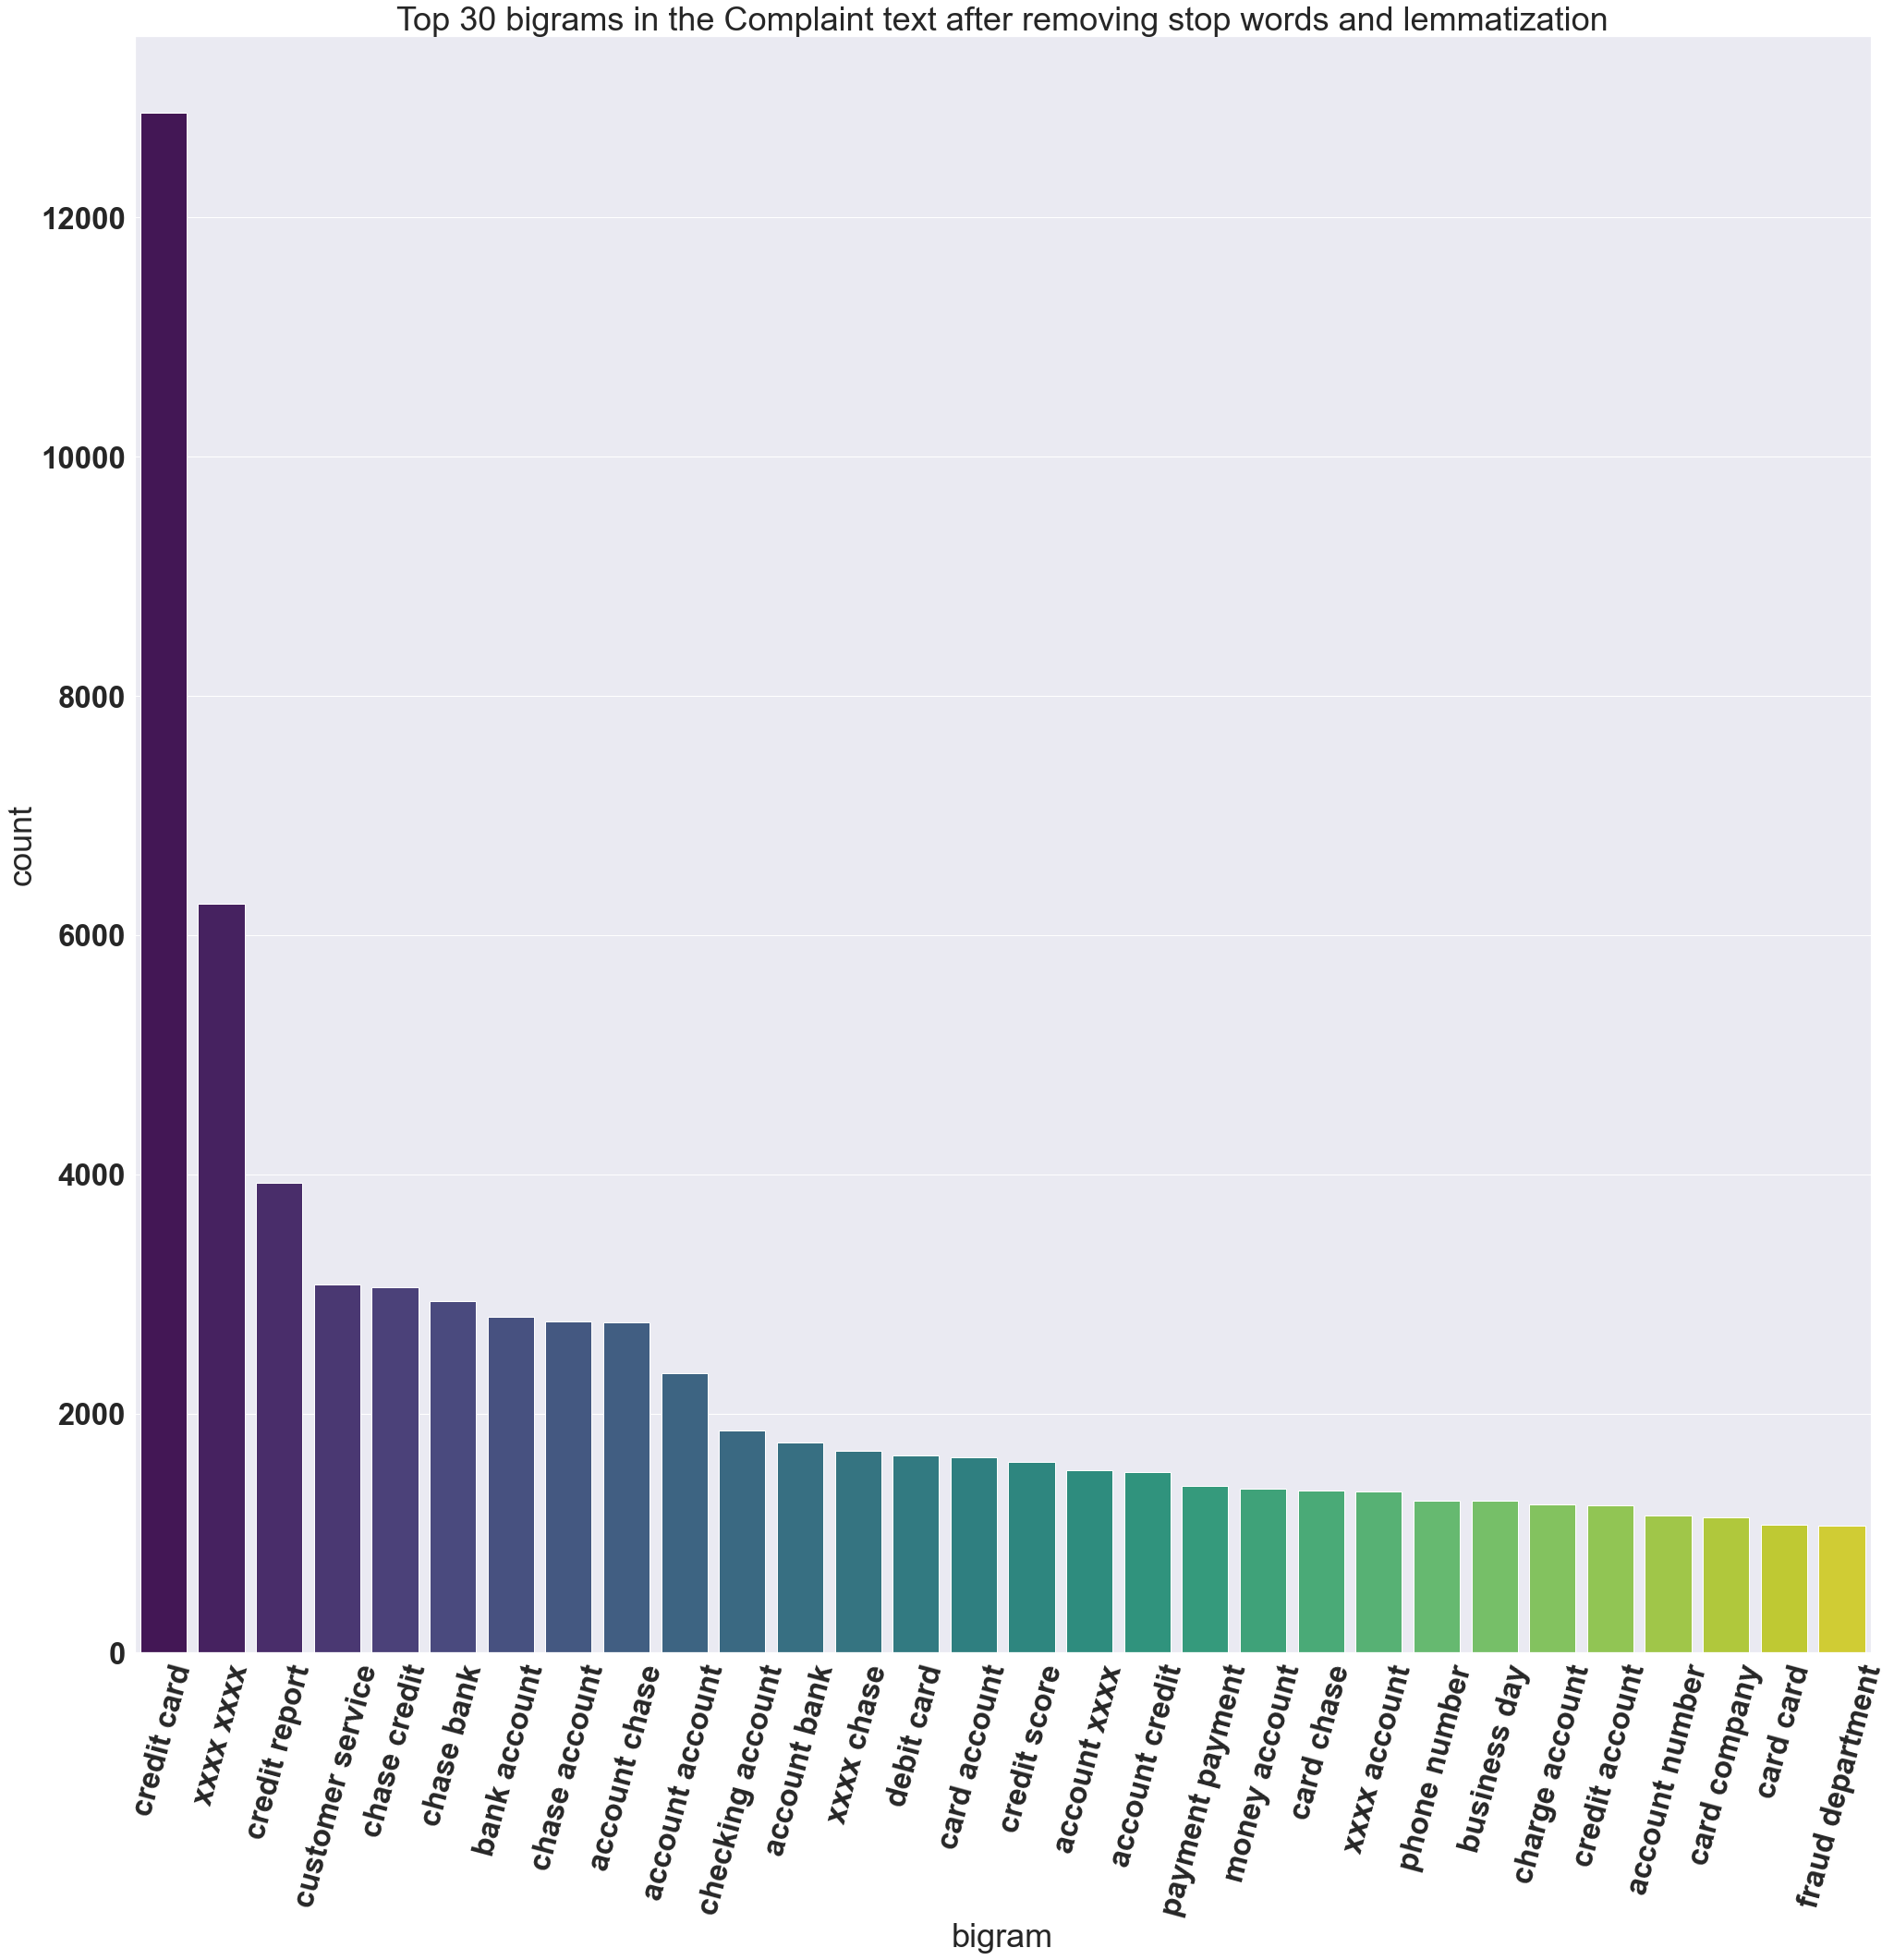

In [38]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
plt.rc('font', **font)
sns.set_style("whitegrid")
sns.set(font_scale = 3)

sns.barplot(x='bigram', y='count',data=df_process_bigram, palette="viridis" )
plt.title('Top 30 bigrams in the Complaint text after removing stop words and lemmatization')
plt.ylabel('count')
plt.xlabel('bigram')
plt.xticks(rotation=75)
plt.show()

#### Similar to unigrams find the top 30 trigrams

In [39]:
def fetch_top_n_trigram(corpus, n=None):
    '''
    Input to this function is a corpus of words and then it return returns the top n words(bigrams) 
    as per their occurances number of times
    data : cleaned input data
    n: number of top words(trigrams) 
    '''
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    summation_of_words = bag_of_words.sum(axis=0) 
    word_frequency = [(word, summation_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_frequency =sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [40]:
#Get the top 30 words in the trigram 
high_common_words = fetch_top_n_trigram(df_process['POS_removed_complaint'].values.astype('U'),30)
df_process_trigram = pd.DataFrame(high_common_words, columns = ['trigram' , 'count'])
df_process_trigram.head(10)

,trigram,count
0,chase credit card,2136
1,xxxx xxxx xxxx,1076
2,credit card account,1061
3,credit card company,995
4,credit card chase,671
5,credit card credit,506
6,inquiry credit report,483
7,charge credit card,429
8,account credit card,417
9,credit reporting agency,382


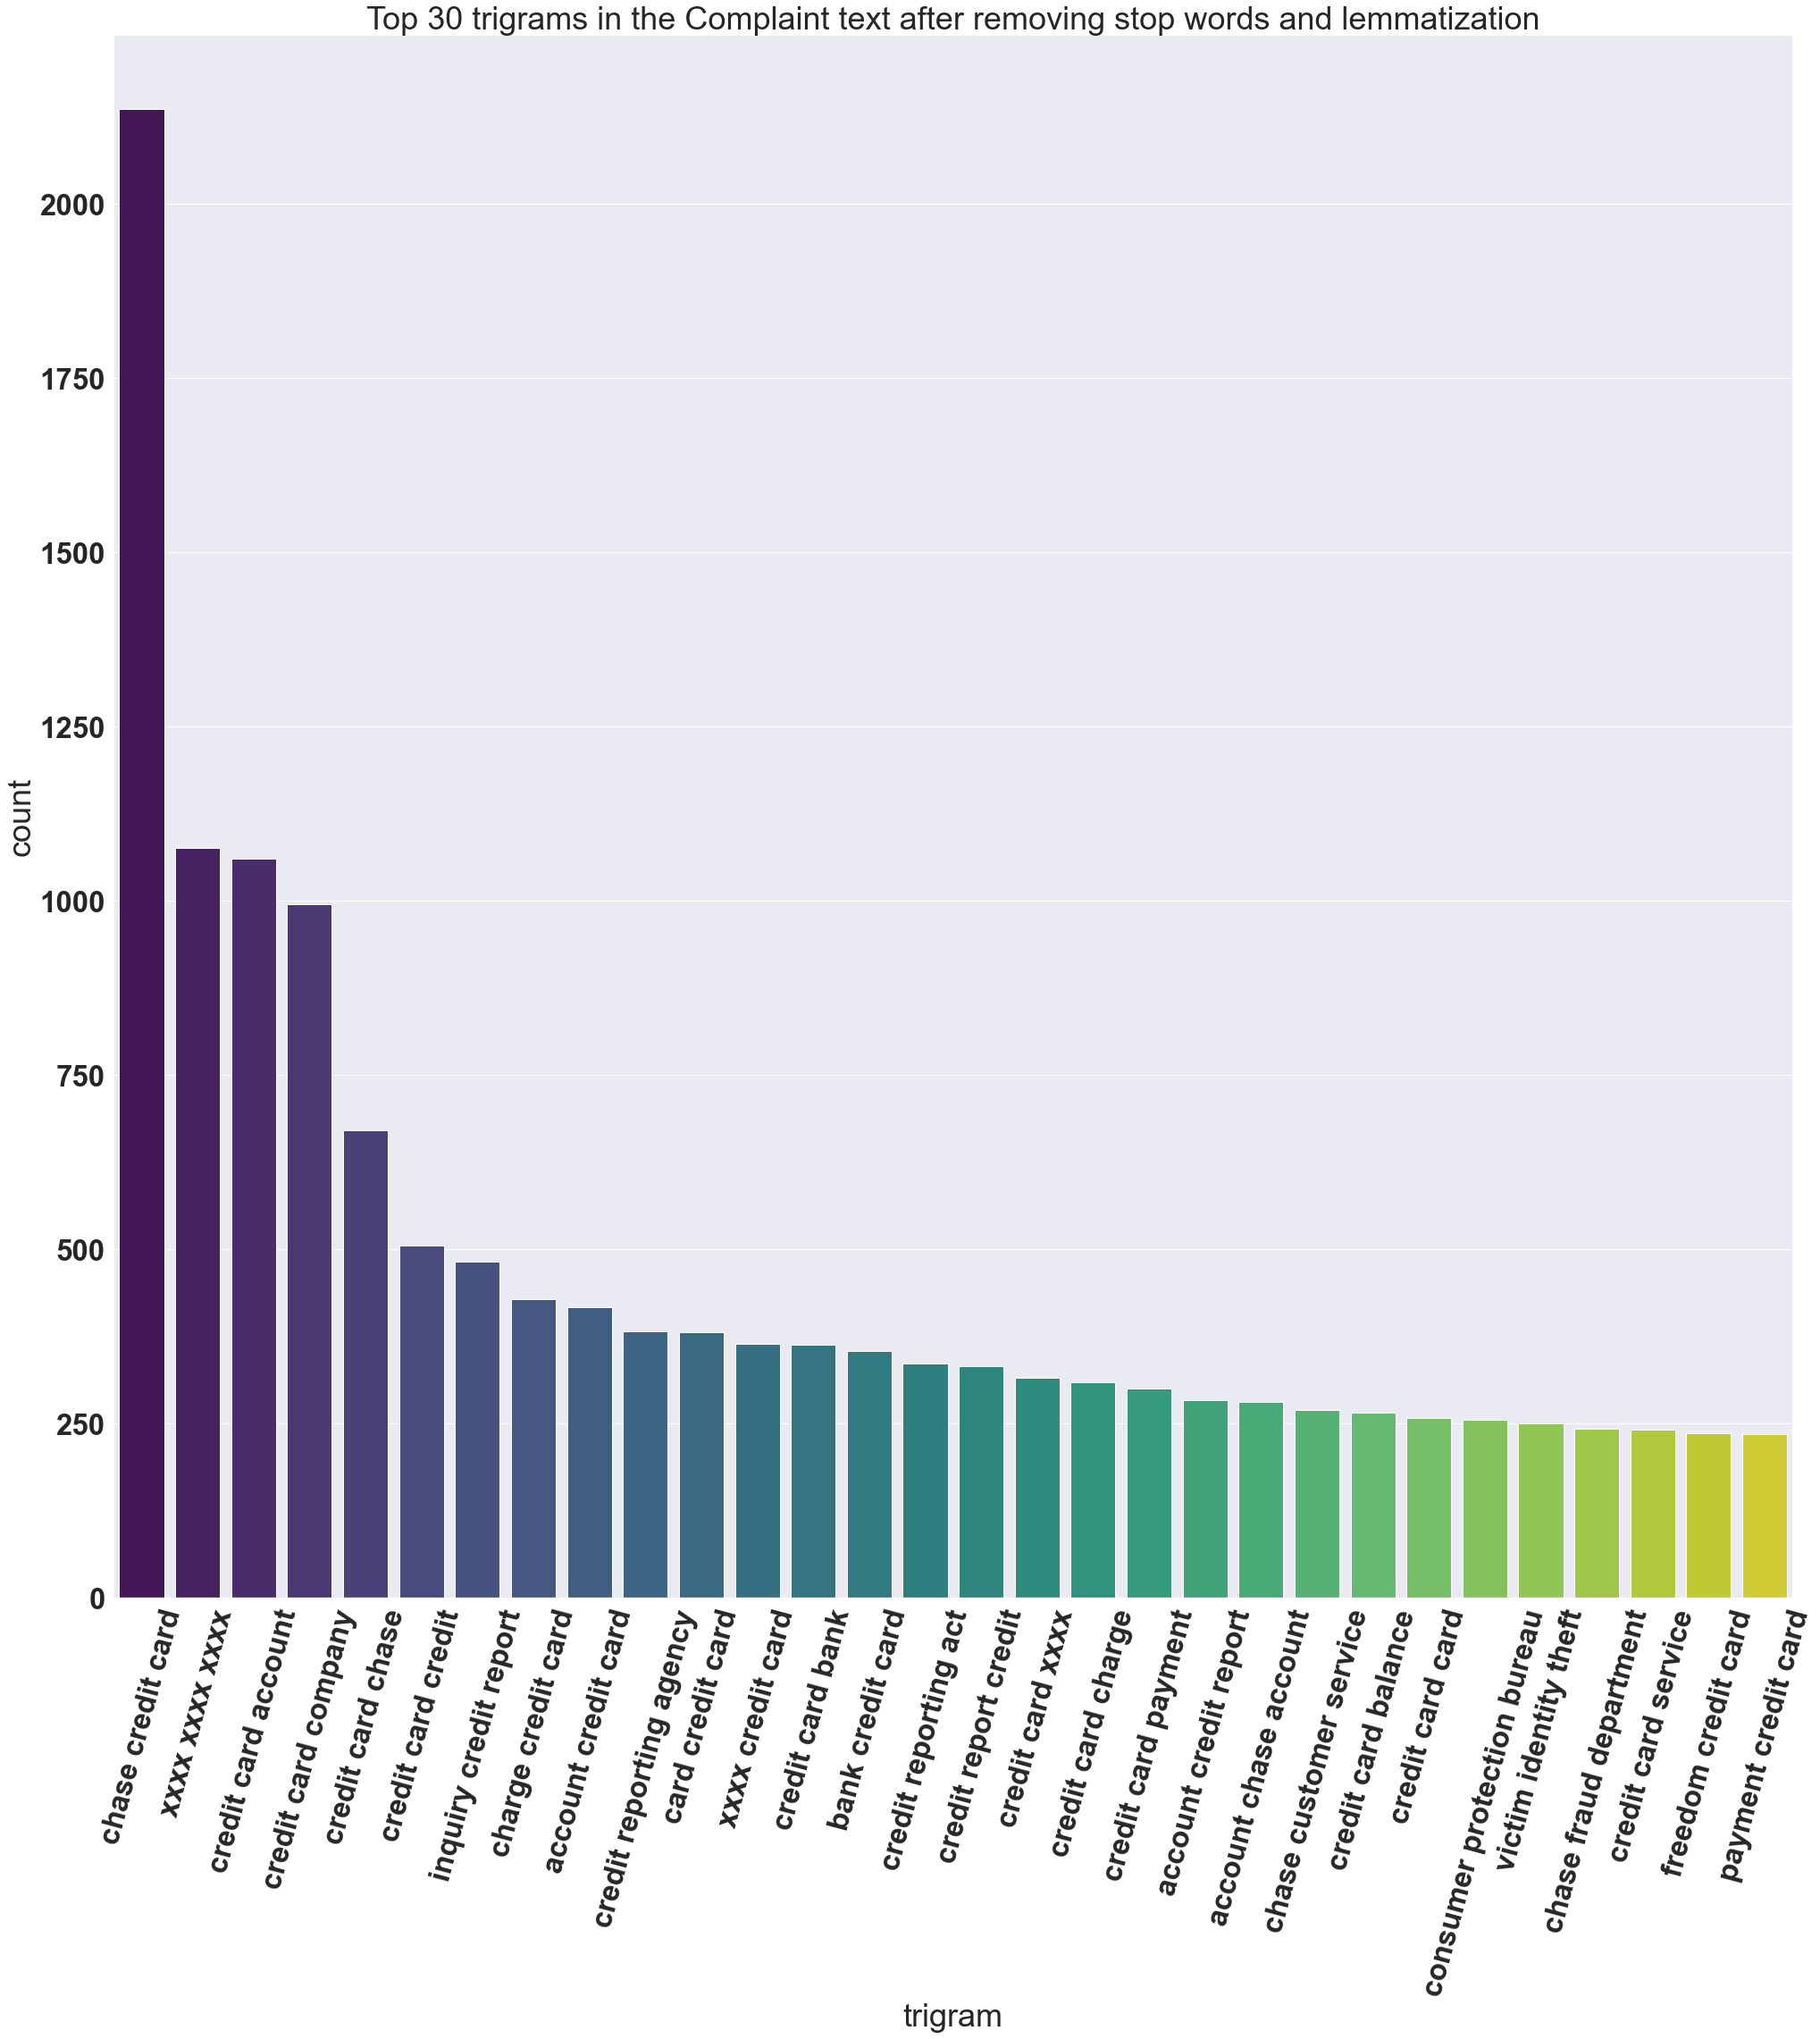

In [41]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
plt.rc('font', **font)
sns.set_style("whitegrid")
sns.set(font_scale = 3)

sns.barplot(x='trigram', y='count',data=df_process_trigram, palette="viridis" )
plt.title('Top 30 trigrams in the Complaint text after removing stop words and lemmatization')
plt.ylabel('count')
plt.xlabel('trigram')
plt.xticks(rotation=75)
plt.show()

### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [42]:
# Remove masks 'xxxx' from complaints
df_process['POS_removed_complaint'] = df_process['POS_removed_complaint'].str.replace('xxxx','')

In [43]:
df_process.head()

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...


In [44]:
df_process.shape

(21072, 3)

 ## <span style="color:Orange">Task 5: Feature extraction </span>

Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
# Initiate the TfidfVectorizer 

In [46]:
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
doc_term_matrix=tfidf.fit_transform(df_process['POS_removed_complaint'])

## <span style="color:Orange">Task 6: Topic Modelling using NMF </span> 

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

**Find the best number of clusters**

**Apply the best number to create word clusters**

**Inspect & validate the correction of each cluster wrt the complaints**

**Correct the labels if needed**

**Map the clusters to topics/cluster names**

####  Manual Topic Modeling

You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

**In order to choose best number of topics lets use Coherence Model**

In [48]:
from gensim.models.nmf import Nmf
from gensim.corpora.dictionary import Dictionary
from operator import itemgetter
from gensim.models.coherencemodel import CoherenceModel


# using Gensim's NMF to fetch the best number of topics using  coherence score matrix
doc_texts = df_process['POS_removed_complaint']
dataset_doc = [i.split() for i in doc_texts]


dictionary_gensim = Dictionary(dataset_doc) # Map the words and their integer id using a dictionary

# Use filters 
dictionary_gensim.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)


corpus_gensim = [dictionary_gensim.doc2bow(text) for text in dataset_doc] # Generate the bag-of-words  


number_of_topics = list(np.arange(5, 10, 1)) # Generate a list of the topic numbers 

# calculate the coherence score corresponding to each topics
coherence_scores_top = []

for i in number_of_topics:
    nmf = Nmf(
        corpus=corpus_gensim,
        num_topics=i,
        id2word=dictionary_gensim,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
#  iteratively run the coherence model
    cm = CoherenceModel(
        model=nmf,
        texts=doc_texts,
        dictionary=dictionary_gensim,
        coherence='c_v'
    )
    
    coherence_scores_top.append(round(cm.get_coherence(), 5))

# Fetch the number of topics with the maximum coherence score
c_scores = list(zip(number_of_topics, coherence_scores_top))
high_score_num_topics = sorted(c_scores, key=itemgetter(1), reverse=True)[0][0]

print(high_score_num_topics)


5


In [49]:
#Load your nmf_model with the n_components i.e 5
nmf_model = NMF(n_components=5, random_state=40)

#keep the random_state =40
nmf_model.fit(doc_term_matrix)

NMF(n_components=5, random_state=40)

In [50]:
# View the number of features
len(tfidf.get_feature_names())

7067

In [51]:
#Print few top words
top_sgl = nmf_model.components_[0]
top_sgl.argsort()
ix_top_word = top_sgl.argsort()[-10:]
for j in ix_top_word:
    print(tfidf.get_feature_names()[j])

checking
day
branch
deposit
chase
fund
money
check
bank
account


In [52]:
#Print the Top15 words for each of the topics

for i,top in enumerate(nmf_model.components_):
    print("Top 15 words for topic {0}:".format(i))
    print([tfidf.get_feature_names()[j] for j in top.argsort()[-15:]])
    print('\n')

Top 15 words for topic 0:
['transfer', 'claim', 'transaction', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


Top 15 words for topic 1:
['year', 'balance', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


Top 15 words for topic 2:
['mortgage', 'year', 'chase', 'credit', 'account', 'date', 'pay', 'time', 'day', 'auto', 'statement', 'fee', 'month', 'balance', 'payment']


Top 15 words for topic 3:
['company', 'refund', 'statement', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'transaction', 'dispute', 'fee', 'chase', 'card', 'charge']


Top 15 words for topic 4:
['sale', 'bank', 'house', 'foreclosure', 'document', 'time', 'rate', 'letter', 'year', 'property', 'modification', 'chase', 'home', 'mortgage', 'loan']




In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
best_topic_res = nmf_model.transform(doc_term_matrix)
best_topic_res[0].round(2)
best_topic_res[0].argmax()
best_topic_res.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2], dtype=int64)

In [54]:
#Assign the best topic to each of the cmplaints in Topic Column

df_process['b_topic'] = best_topic_res.argmax(axis=1)


df_process.head() # View the dataframe

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint,b_topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,0


In [55]:
df_process.shape

(21072, 4)

In [56]:
#Print the first 5 Complaint for each of the Topics
df_process_final=df_process.groupby('b_topic').head(5)
df_process_final.sort_values('b_topic')

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint,b_topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p chase account debit card tuesday branch cu...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,1


In [57]:
df_process_final.shape

(25, 4)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [58]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"} 
#Replace Topics with Topic Names
df_process['b_topic'] = df_process['b_topic'].map(Topic_names)

In [59]:
# View dataframe
df_process.head()

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint,b_topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,Bank Account services


In [60]:
df_process.shape

(21072, 4)

## <span style="color:Orange">Task 7: Model building with the help of supervised learning </span> 

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [61]:
# Create the dictionary again of Topic names and Topic numbers
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}

# Replace Topic Names with Topic numbers
df_process['b_topic'] = df_process['b_topic'].map(Topic_names)

In [62]:
# View Dataframe

df_process.head()

,complaint_what_happened,complaint_lemmatize,POS_removed_complaint,b_topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card application identity consent service cred...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",try book ticket offer ticket card information...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund bank account pay money ...,0


In [63]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_process[["complaint_what_happened","b_topic"]]

In [64]:
training_data

,complaint_what_happened,b_topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs. i've had ...,2


In [65]:
training_data.shape

(21072, 2)

In [66]:
# Check the counts of topics

training_data['b_topic'].value_counts()

0    5217
1    4971
3    4801
4    3809
2    2274
Name: b_topic, dtype: int64

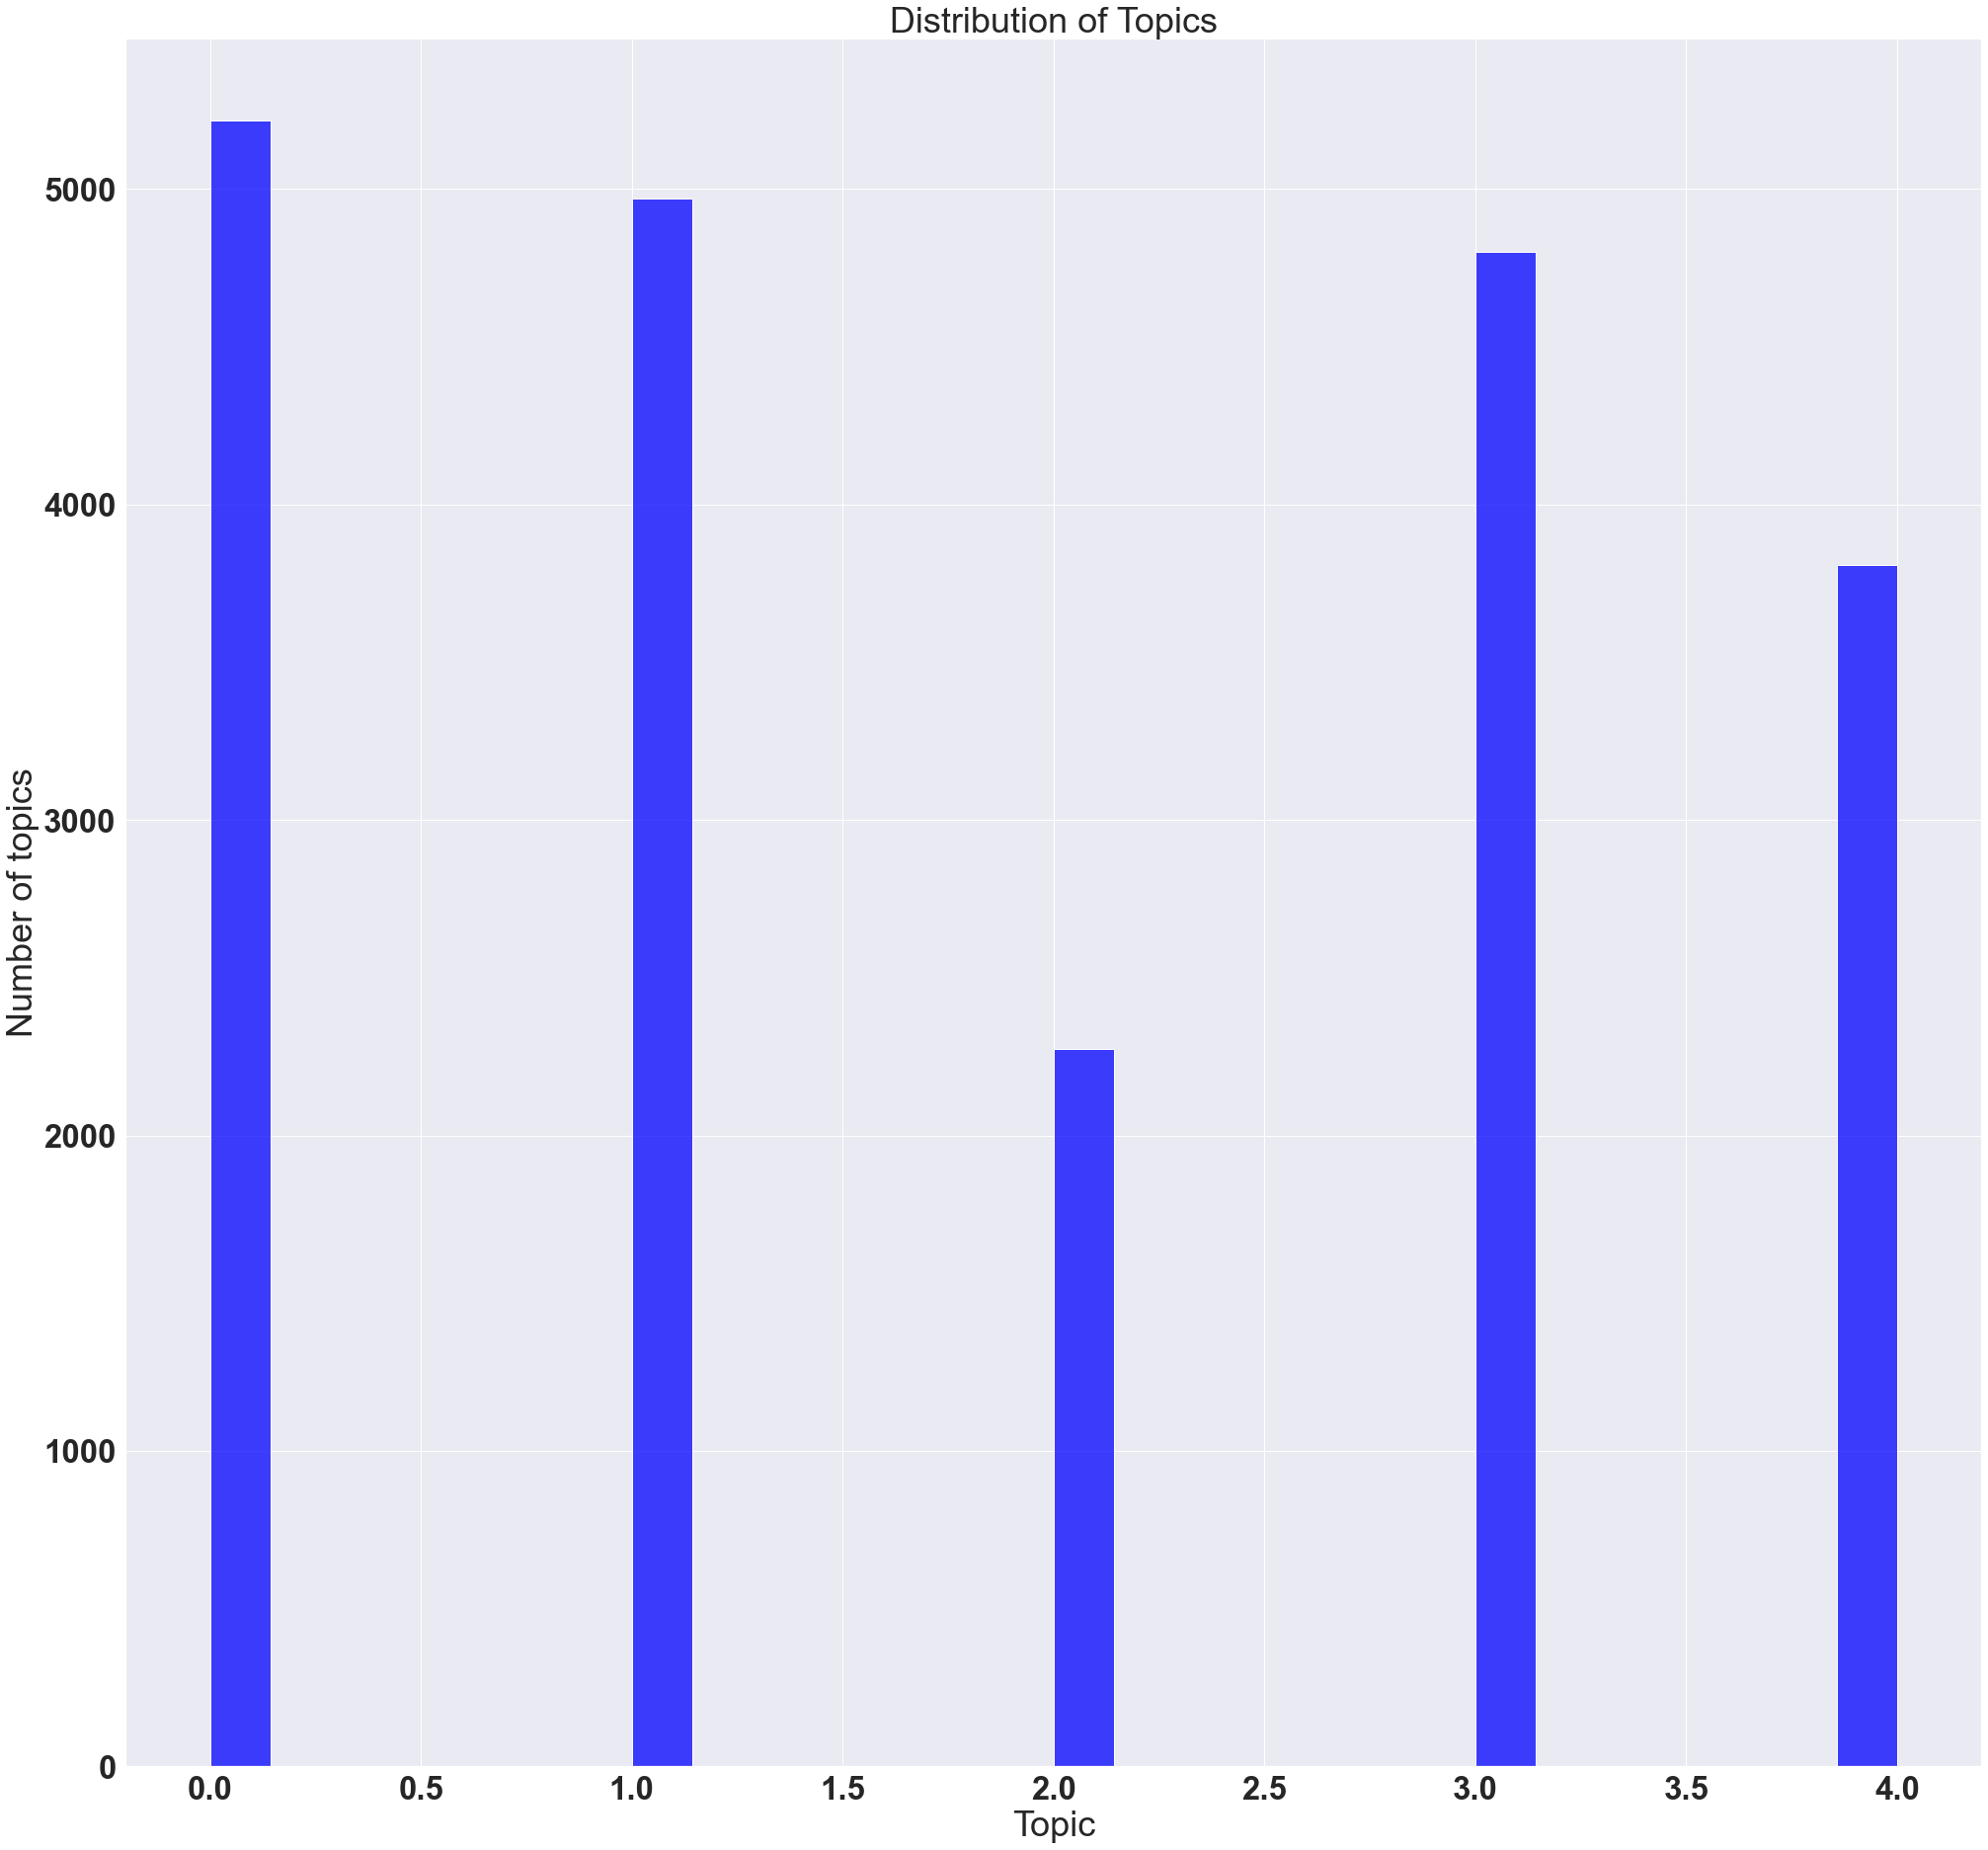

In [67]:
# Visualize the data 
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 30))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
plt.rc('font', **font)
sns.set_style("whitegrid")
sns.set(font_scale = 3)

sns.histplot(data=training_data, x='b_topic',color='Blue',)
plt.title('Distribution of Topics')
plt.ylabel('Number of topics')
plt.xlabel('Topic')
plt.show()

####  Apply the supervised models on the training data created. In this process, you have to do the following:

* Create the vector counts using Count Vectoriser

* Transform the word vecotr to tf-idf

* Create the train & test data using the train_test_split on the tf-idf & topics

In [68]:
# The Vector count

vect_cnt = CountVectorizer()

cnt_X_train = vect_cnt.fit_transform(training_data['complaint_what_happened'])

In [69]:
# Add a Word Vector

pickle.dump(vect_cnt.vocabulary_, open("count_vector.pkl","wb"))

In [70]:
# Transform word vector to tf-idf

transform_tfidf= TfidfTransformer()

tfidf_X_train = transform_tfidf.fit_transform(cnt_X_train)

In [71]:
# add TF-IDF 

pickle.dump(transform_tfidf, open("tfidf.pkl","wb"))

In [72]:
training_data.shape

(21072, 2)

In [73]:
# Get Train-Test split
X_train, X_test, y_train, y_test = train_test_split(tfidf_X_train, training_data.b_topic, test_size=0.3, random_state=42)

print("X_train Shape {0}:".format(X_train.shape))
print("y_train Shape {0}:".format(y_train.shape))
print("X_test Shape {0}:".format(X_test.shape))
print("y_test Shape {0}:".format(y_test.shape))

X_train Shape (14750, 27984):
y_train Shape (14750,):
X_test Shape (6322, 27984):
y_test Shape (6322,):


You have to try atleast 3 models on the train & test data from these options:

* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)
* XGBoost

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**Creating a function to evaluate the above mentioned models**

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [75]:
def evalution_different_model(y_test, y_pred, model_name):
    

        
    '''
    Input to this function is a target test variable, target predicted variable from different models
    then print classification report and it return none 
    y_test: actual labels
    data : predicted labels
    models name: viz Logistic regression, Decision tree, Random Forest, XGBoost, Naive Bayes 
    '''
    
    
    print(f"CLASSIFICATION REPORT for {model_name}\n") # print classification report of given model
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting","Mortgage/Loan"]))
    
    # plotting confusion matrix of given model
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(30, 30))
    font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 50}
    plt.rc('font', **font)
    sns.set_style("whitegrid")
    sns.set(font_scale = 3)
    plt.title(f"CONFUSION MATRIX for{0}:".format(model_name))
    conf_matrix = confusion_matrix(y_test, y_pred)
    # a custom divergin palette
    cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
    sns.heatmap(conf_matrix, center=0, annot=True,fmt='.2f', square=True, cmap=cmap,xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
    "Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
    "Mortgage/Loan"])
    plt.show()
    
    return

### We need to use the F1 Score parameter for evalution matrix and weighted average due to class imbalance while evaluting different models

## <span style="color:Orange">Task 8: Model training & evaluation</span> 

### Model :1 #Naive Bayes

In [76]:
# Initial run of the Multinomial Naive Bayes with default parameters
model_name = 'NAIVE BAYES'
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_y_pred = nb_clf.predict(X_test)

In [77]:
# Calculate F1 Score 
nb_f1_score = f1_score(y_test, nb_y_pred, average="weighted")
nb_f1_score

0.67938131750022

#### Hyperparameter tuning to get best result

In [78]:
nb_param = {
    'alpha': (0.00001,0.0001,0.001, 0.01, 0.1,1),
    'fit_prior':[True, False]
}

nb_grid = GridSearchCV(estimator=nb_clf, 
                       param_grid=nb_param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
nb_grid.fit(X_train, y_train)
print(nb_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 0.1, 'fit_prior': False}


In [79]:
# running Naive Bayes with best parameters 

nb_clf_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
nb_clf_tuned.fit(X_train, y_train)
nb_tuned_y_pred = nb_clf_tuned.predict(X_test)

In [80]:
# Calculate F1 Score 
nb_f1_score_tuned = f1_score(y_test, nb_tuned_y_pred, average="weighted")
nb_f1_score_tuned

0.7814777701360724

CLASSIFICATION REPORT for NAIVE BAYES

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.84      0.81      1580
Credit card or prepaid card       0.81      0.75      0.78      1519
                     Others       0.67      0.65      0.66       681
    Theft/Dispute Reporting       0.78      0.77      0.78      1436
              Mortgage/Loan       0.83      0.84      0.84      1106

                   accuracy                           0.78      6322
                  macro avg       0.77      0.77      0.77      6322
               weighted avg       0.78      0.78      0.78      6322



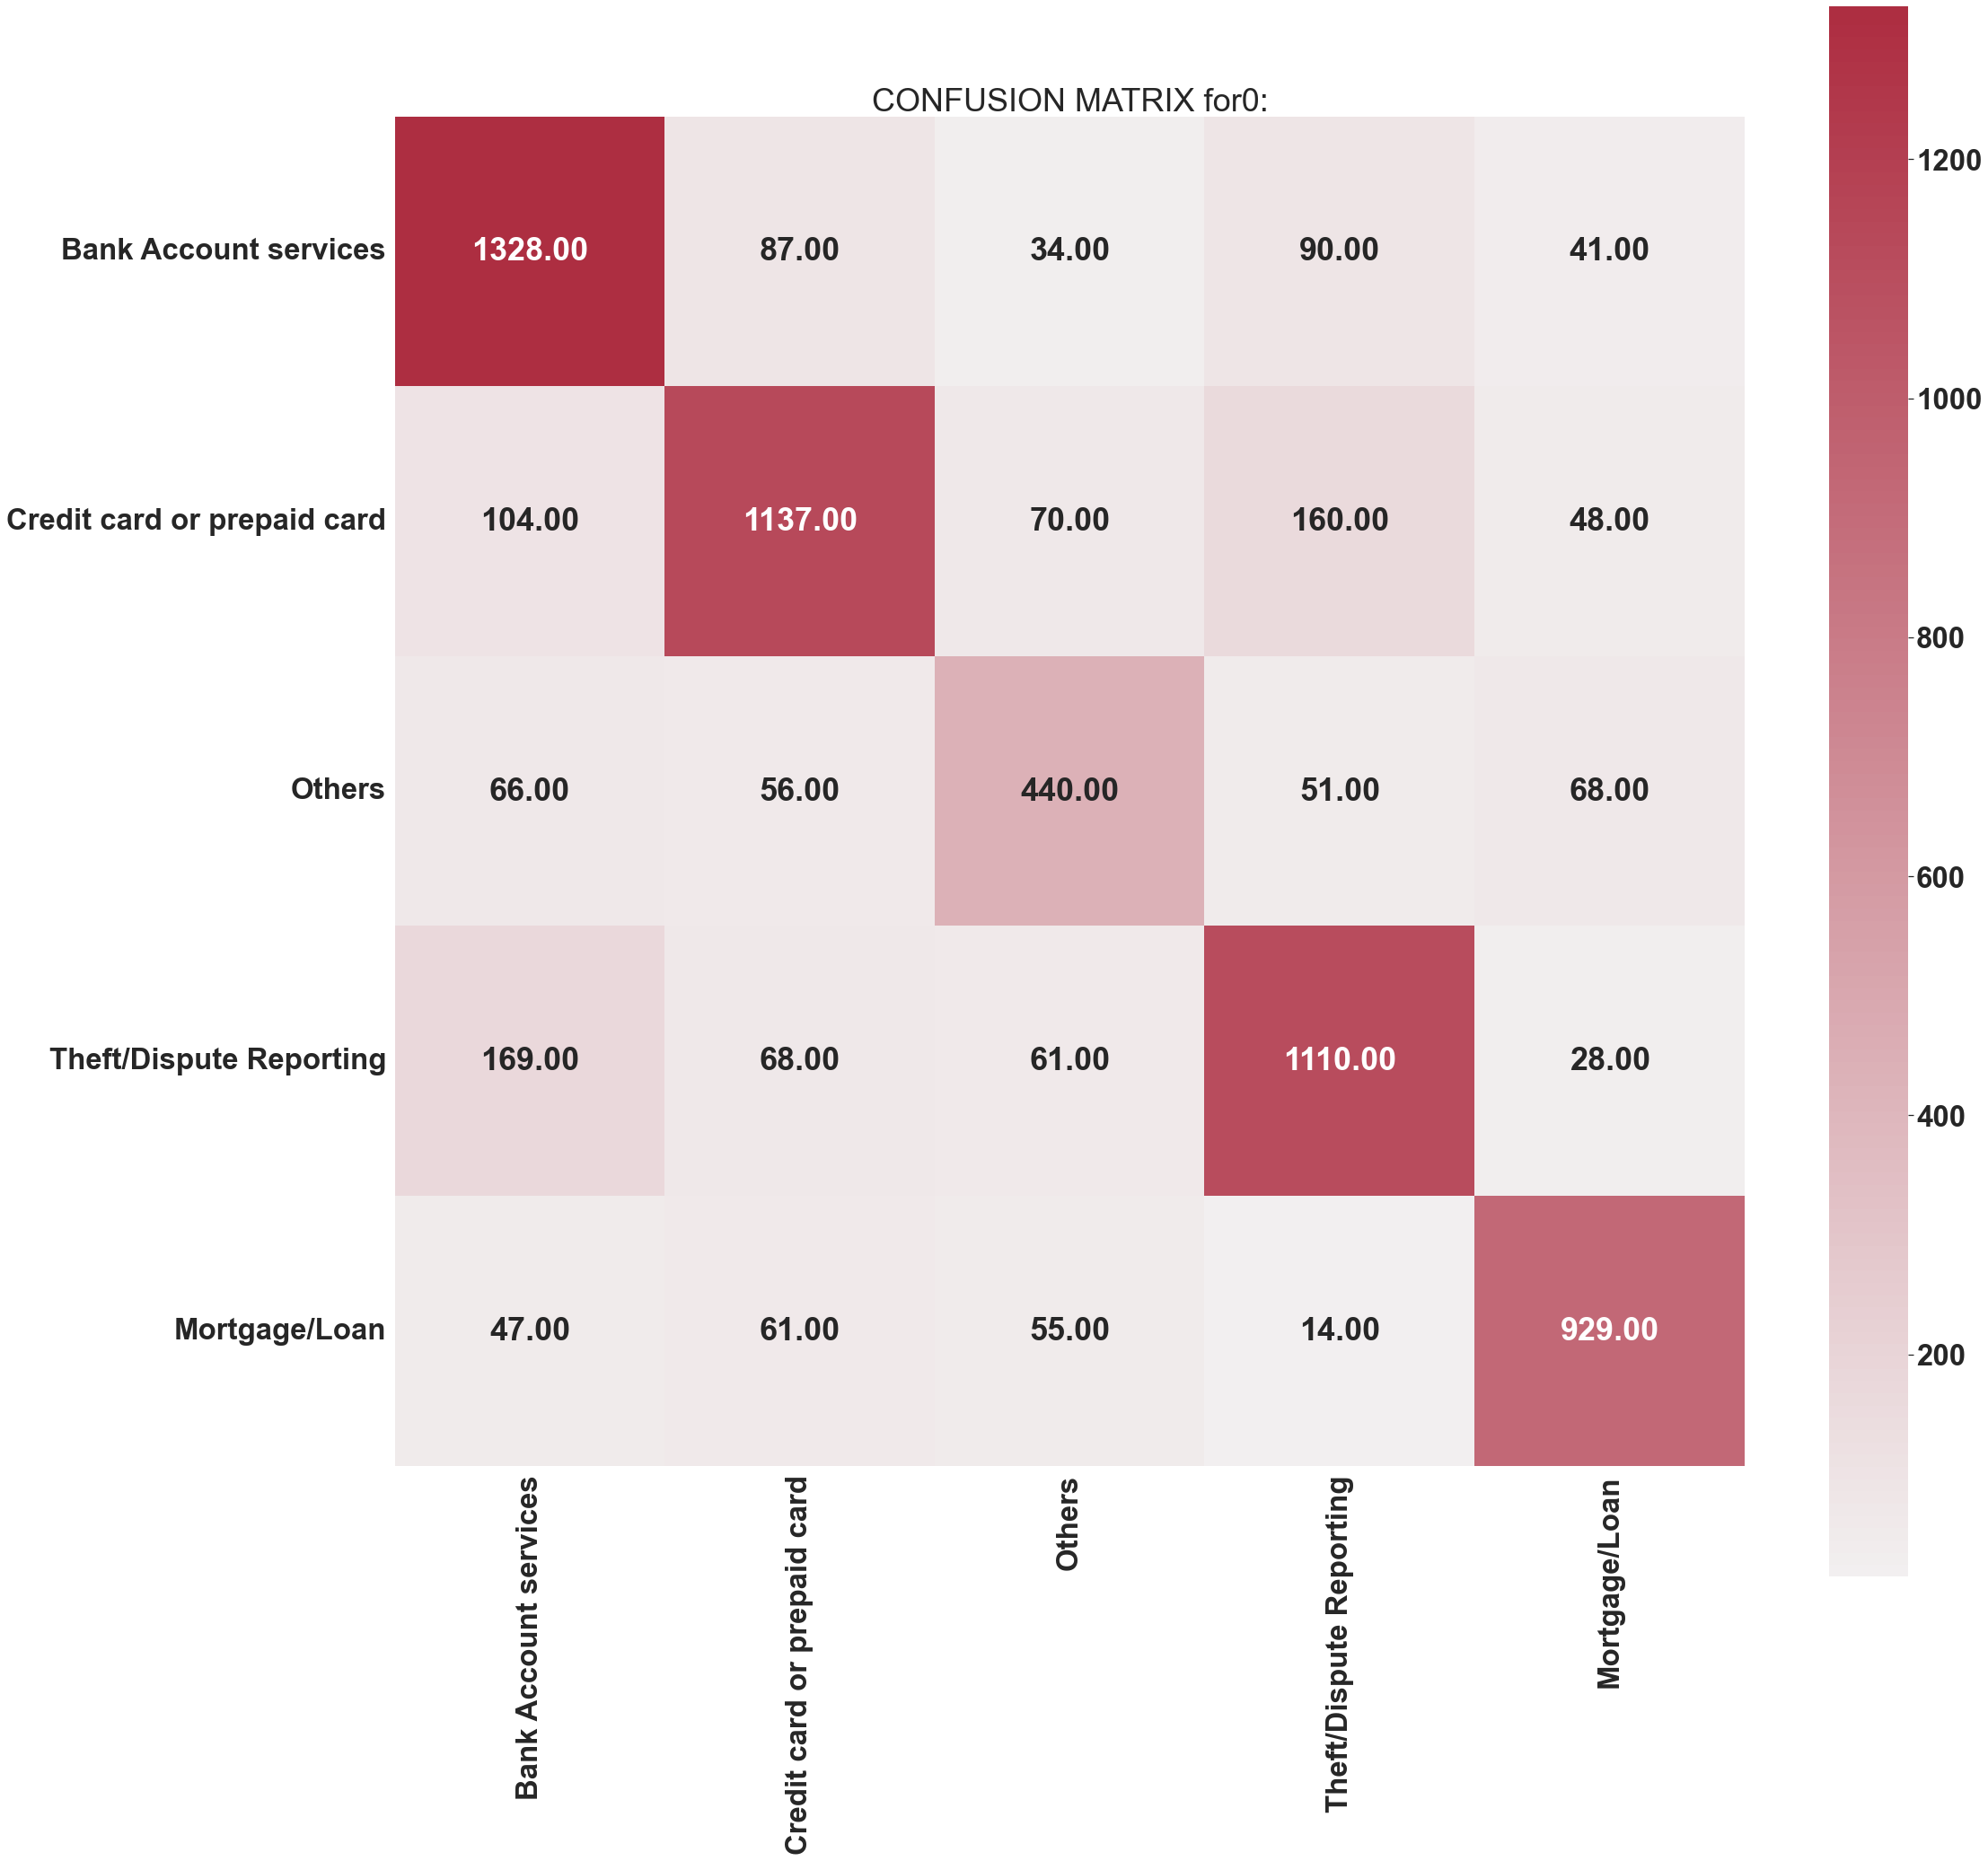

In [81]:
# Evaluate  Naive Bayes classifier with best parameters
evalution_different_model(y_test, nb_tuned_y_pred, model_name)

Observation : **The F1 Score of Naive Bayes model with tuned parameters gives is ~0.78**

In [82]:
# A dataframe to insert F1 Scores for all subsequent models

In [83]:
f1_score_summary = pd.DataFrame([{'Model': 'Naive_Bayes','F1_Score': round(nb_f1_score_tuned, 2)}])
f1_score_summary

,Model,F1_Score
0,Naive_Bayes,0.78


### Model :2 # Logistic regression

In [84]:
# Initial run of the Logistic Regression
model_name = 'Logistic Regression'
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_y_pred = lr_clf.predict(X_test)

In [85]:
# Calculate F1 Score 
lr_f1_score = f1_score(y_test, lr_y_pred, average="weighted")
lr_f1_score

0.920561243283451

#### Hyperparameter tuning to get best result

In [86]:
lr_param = {
    'penalty': ['l1', 'l2','elasticnet', 'none'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

lr_grid = GridSearchCV(estimator=lr_clf, 
                       param_grid=lr_param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [87]:
# running Logistic Regression with best parameters 

lr_clf_tuned = LogisticRegression(C=1, penalty='l1',solver='saga')
lr_clf_tuned.fit(X_train, y_train)
lr_tuned_y_pred = lr_clf_tuned.predict(X_test)

In [88]:
# Calculate F1 Score 
lr_f1_score_tuned = f1_score(y_test, lr_tuned_y_pred, average="weighted")
lr_f1_score_tuned

0.9436140072331753

CLASSIFICATION REPORT for Logistic Regression

                             precision    recall  f1-score   support

      Bank Account services       0.95      0.96      0.95      1580
Credit card or prepaid card       0.95      0.95      0.95      1519
                     Others       0.94      0.95      0.95       681
    Theft/Dispute Reporting       0.94      0.91      0.92      1436
              Mortgage/Loan       0.94      0.94      0.94      1106

                   accuracy                           0.94      6322
                  macro avg       0.94      0.94      0.94      6322
               weighted avg       0.94      0.94      0.94      6322



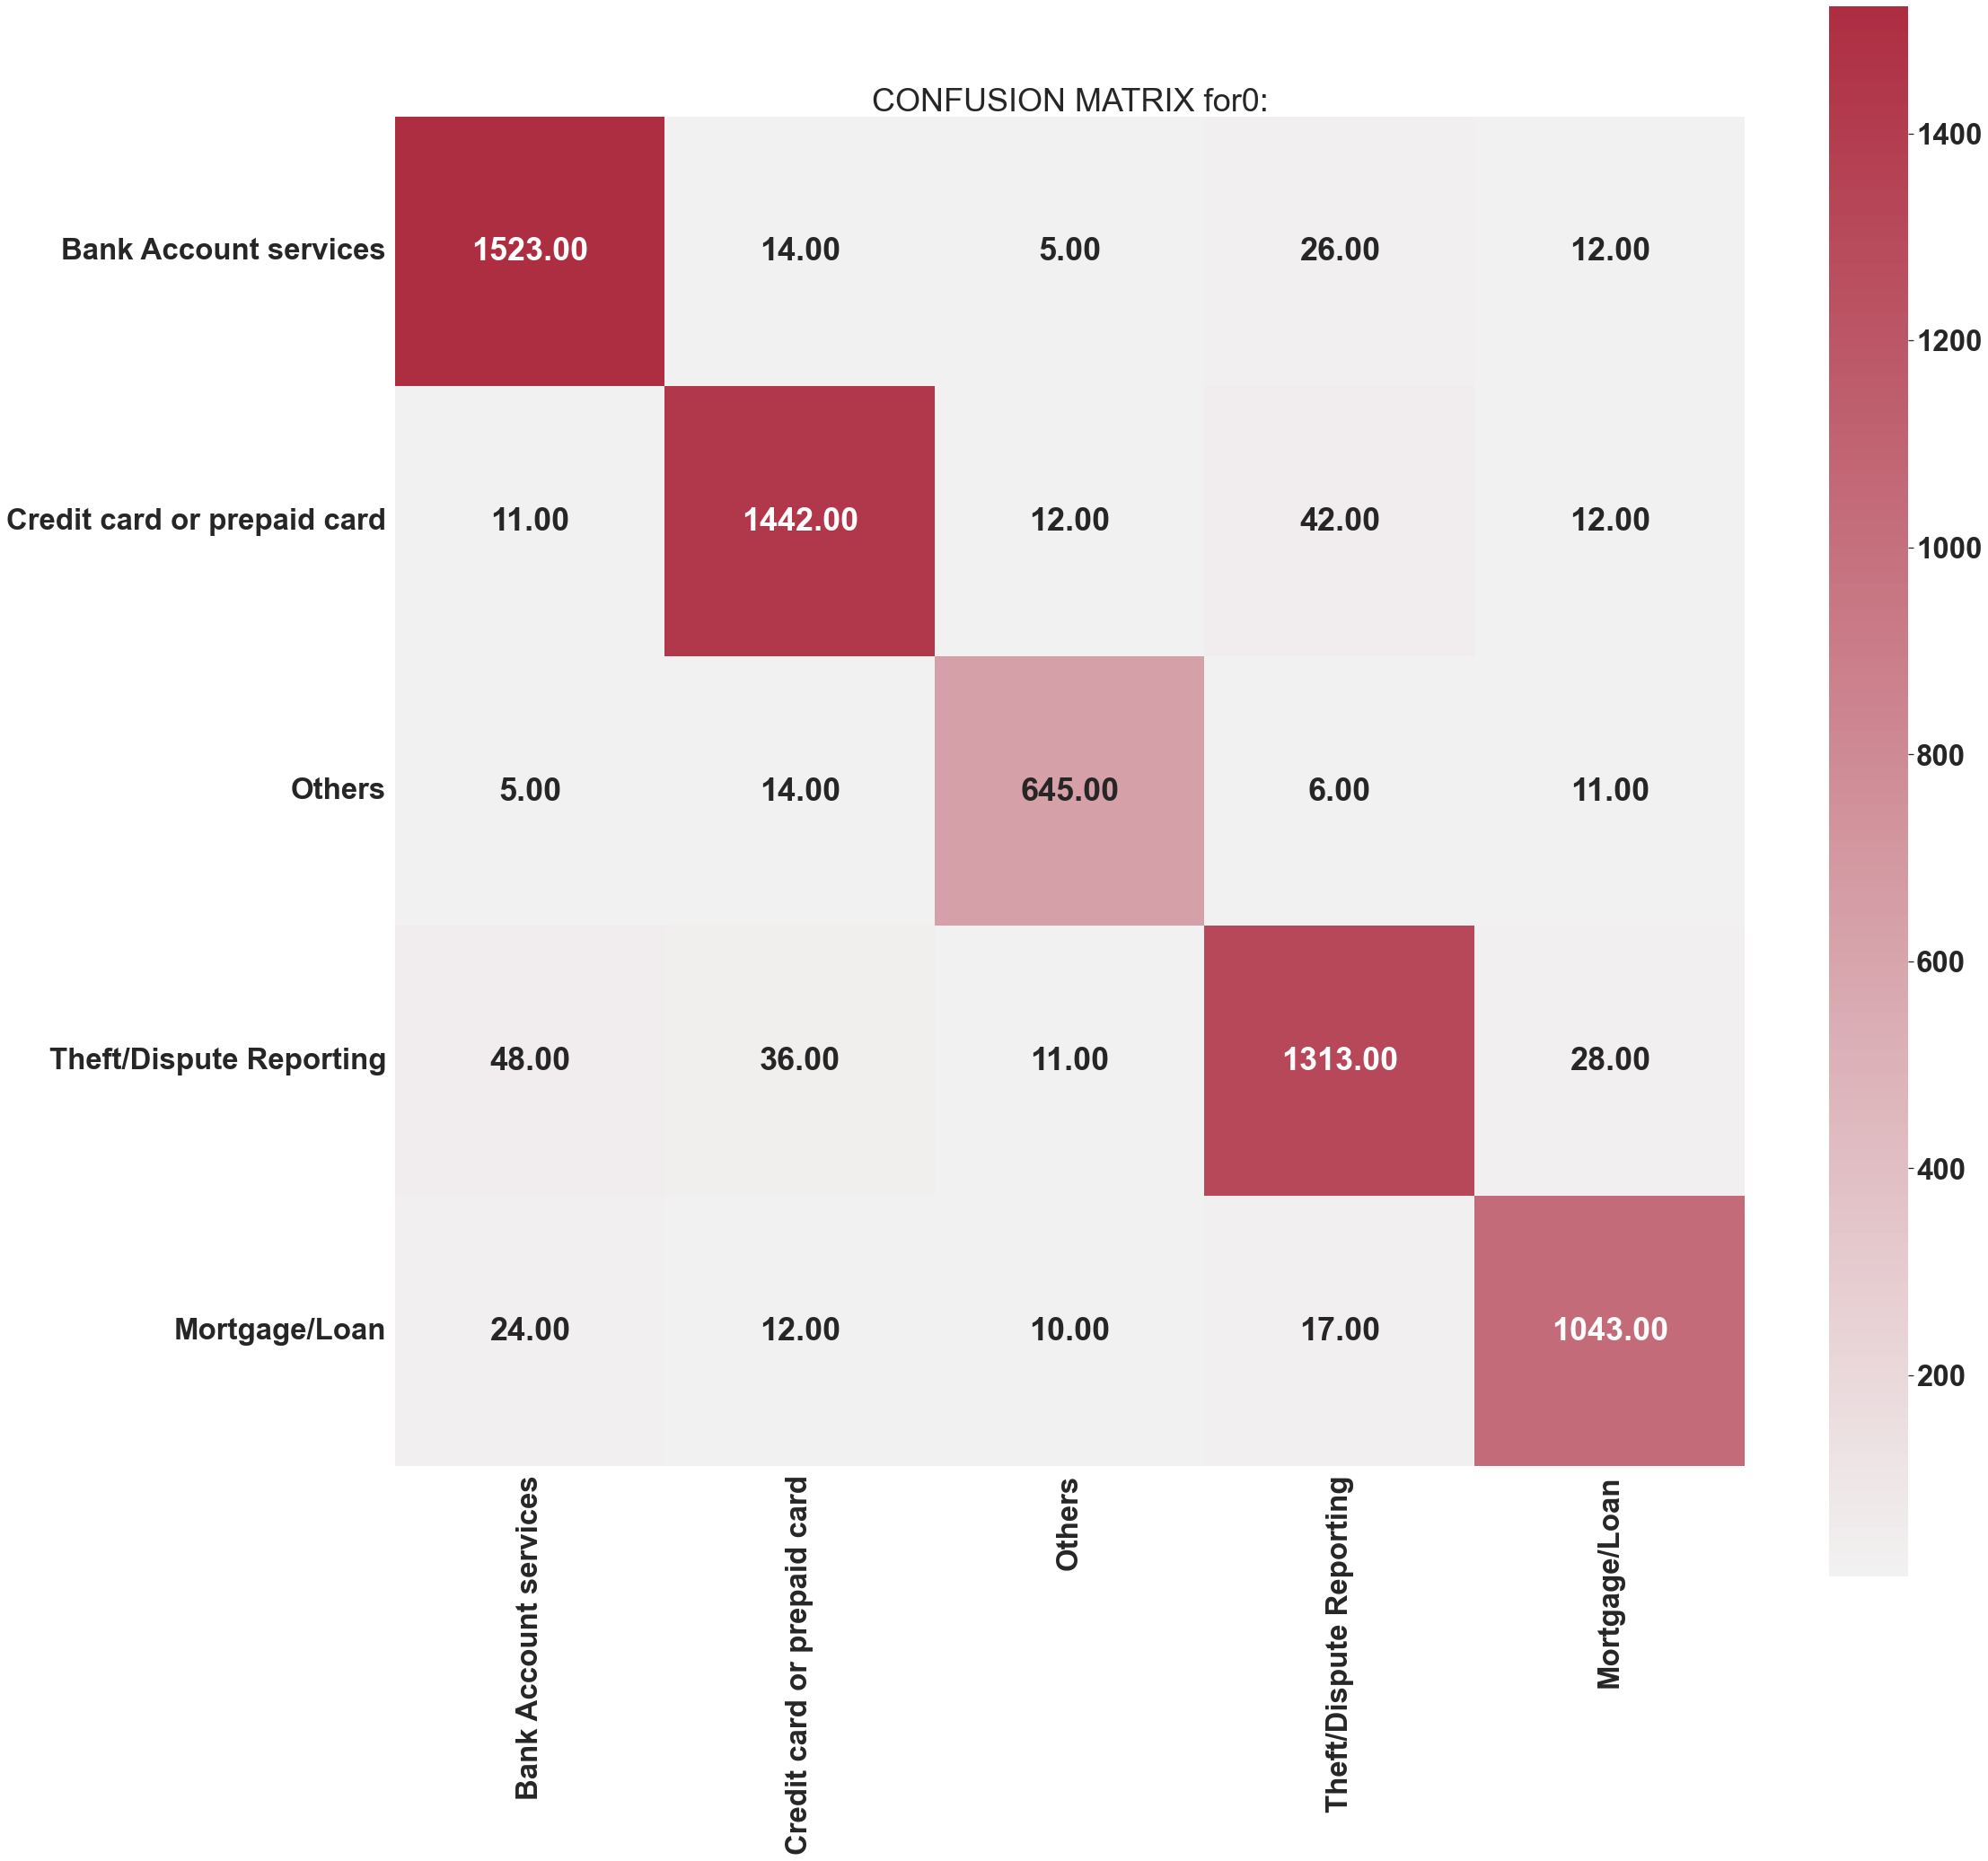

In [89]:
# Evaluate  Logistic Regression classifier with best parameters
evalution_different_model(y_test, lr_tuned_y_pred, model_name)

Observation : **The F1 Score of Logistic Regression model with tuned parameters gives is ~0.94**

In [90]:
f1_score_summary.loc[len(f1_score_summary.index)] = ['Logistic_Regression', round(lr_f1_score_tuned, 2)]
f1_score_summary

,Model,F1_Score
0,Naive_Bayes,0.78
1,Logistic_Regression,0.94


### Model :3 # Decision Tree

In [91]:
# Initial run of the Decision Tree
model_name = 'Decision Tree'
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_y_pred = dt_clf.predict(X_test)

In [92]:
# Calculate F1 Score 
dt_f1_score = f1_score(y_test, dt_y_pred, average="weighted")
dt_f1_score

0.7806562450044896

#### Hyperparameter tuning to get best result

In [93]:
dt_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    'max_features':['auto','log2','sqrt',None],
}

dt_grid = GridSearchCV(estimator=dt_clf, 
                       param_grid=dt_param,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
dt_grid.fit(X_train, y_train)
print(dt_grid.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
{'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 20}


In [94]:
# running Decision Tree with best parameters 

dt_clf_tuned = DecisionTreeClassifier(criterion='entropy',max_depth=25,min_samples_leaf=20,max_features=None)
dt_clf_tuned.fit(X_train, y_train)
dt_tuned_y_pred = dt_clf_tuned.predict(X_test)

In [95]:
# Calculate F1 Score 
dt_f1_score_tuned = f1_score(y_test, dt_tuned_y_pred, average="weighted")
dt_f1_score_tuned

0.7915867109374314

CLASSIFICATION REPORT for Decision Tree

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.82      0.81      1580
Credit card or prepaid card       0.82      0.81      0.81      1519
                     Others       0.76      0.80      0.78       681
    Theft/Dispute Reporting       0.75      0.72      0.73      1436
              Mortgage/Loan       0.81      0.82      0.81      1106

                   accuracy                           0.79      6322
                  macro avg       0.79      0.79      0.79      6322
               weighted avg       0.79      0.79      0.79      6322



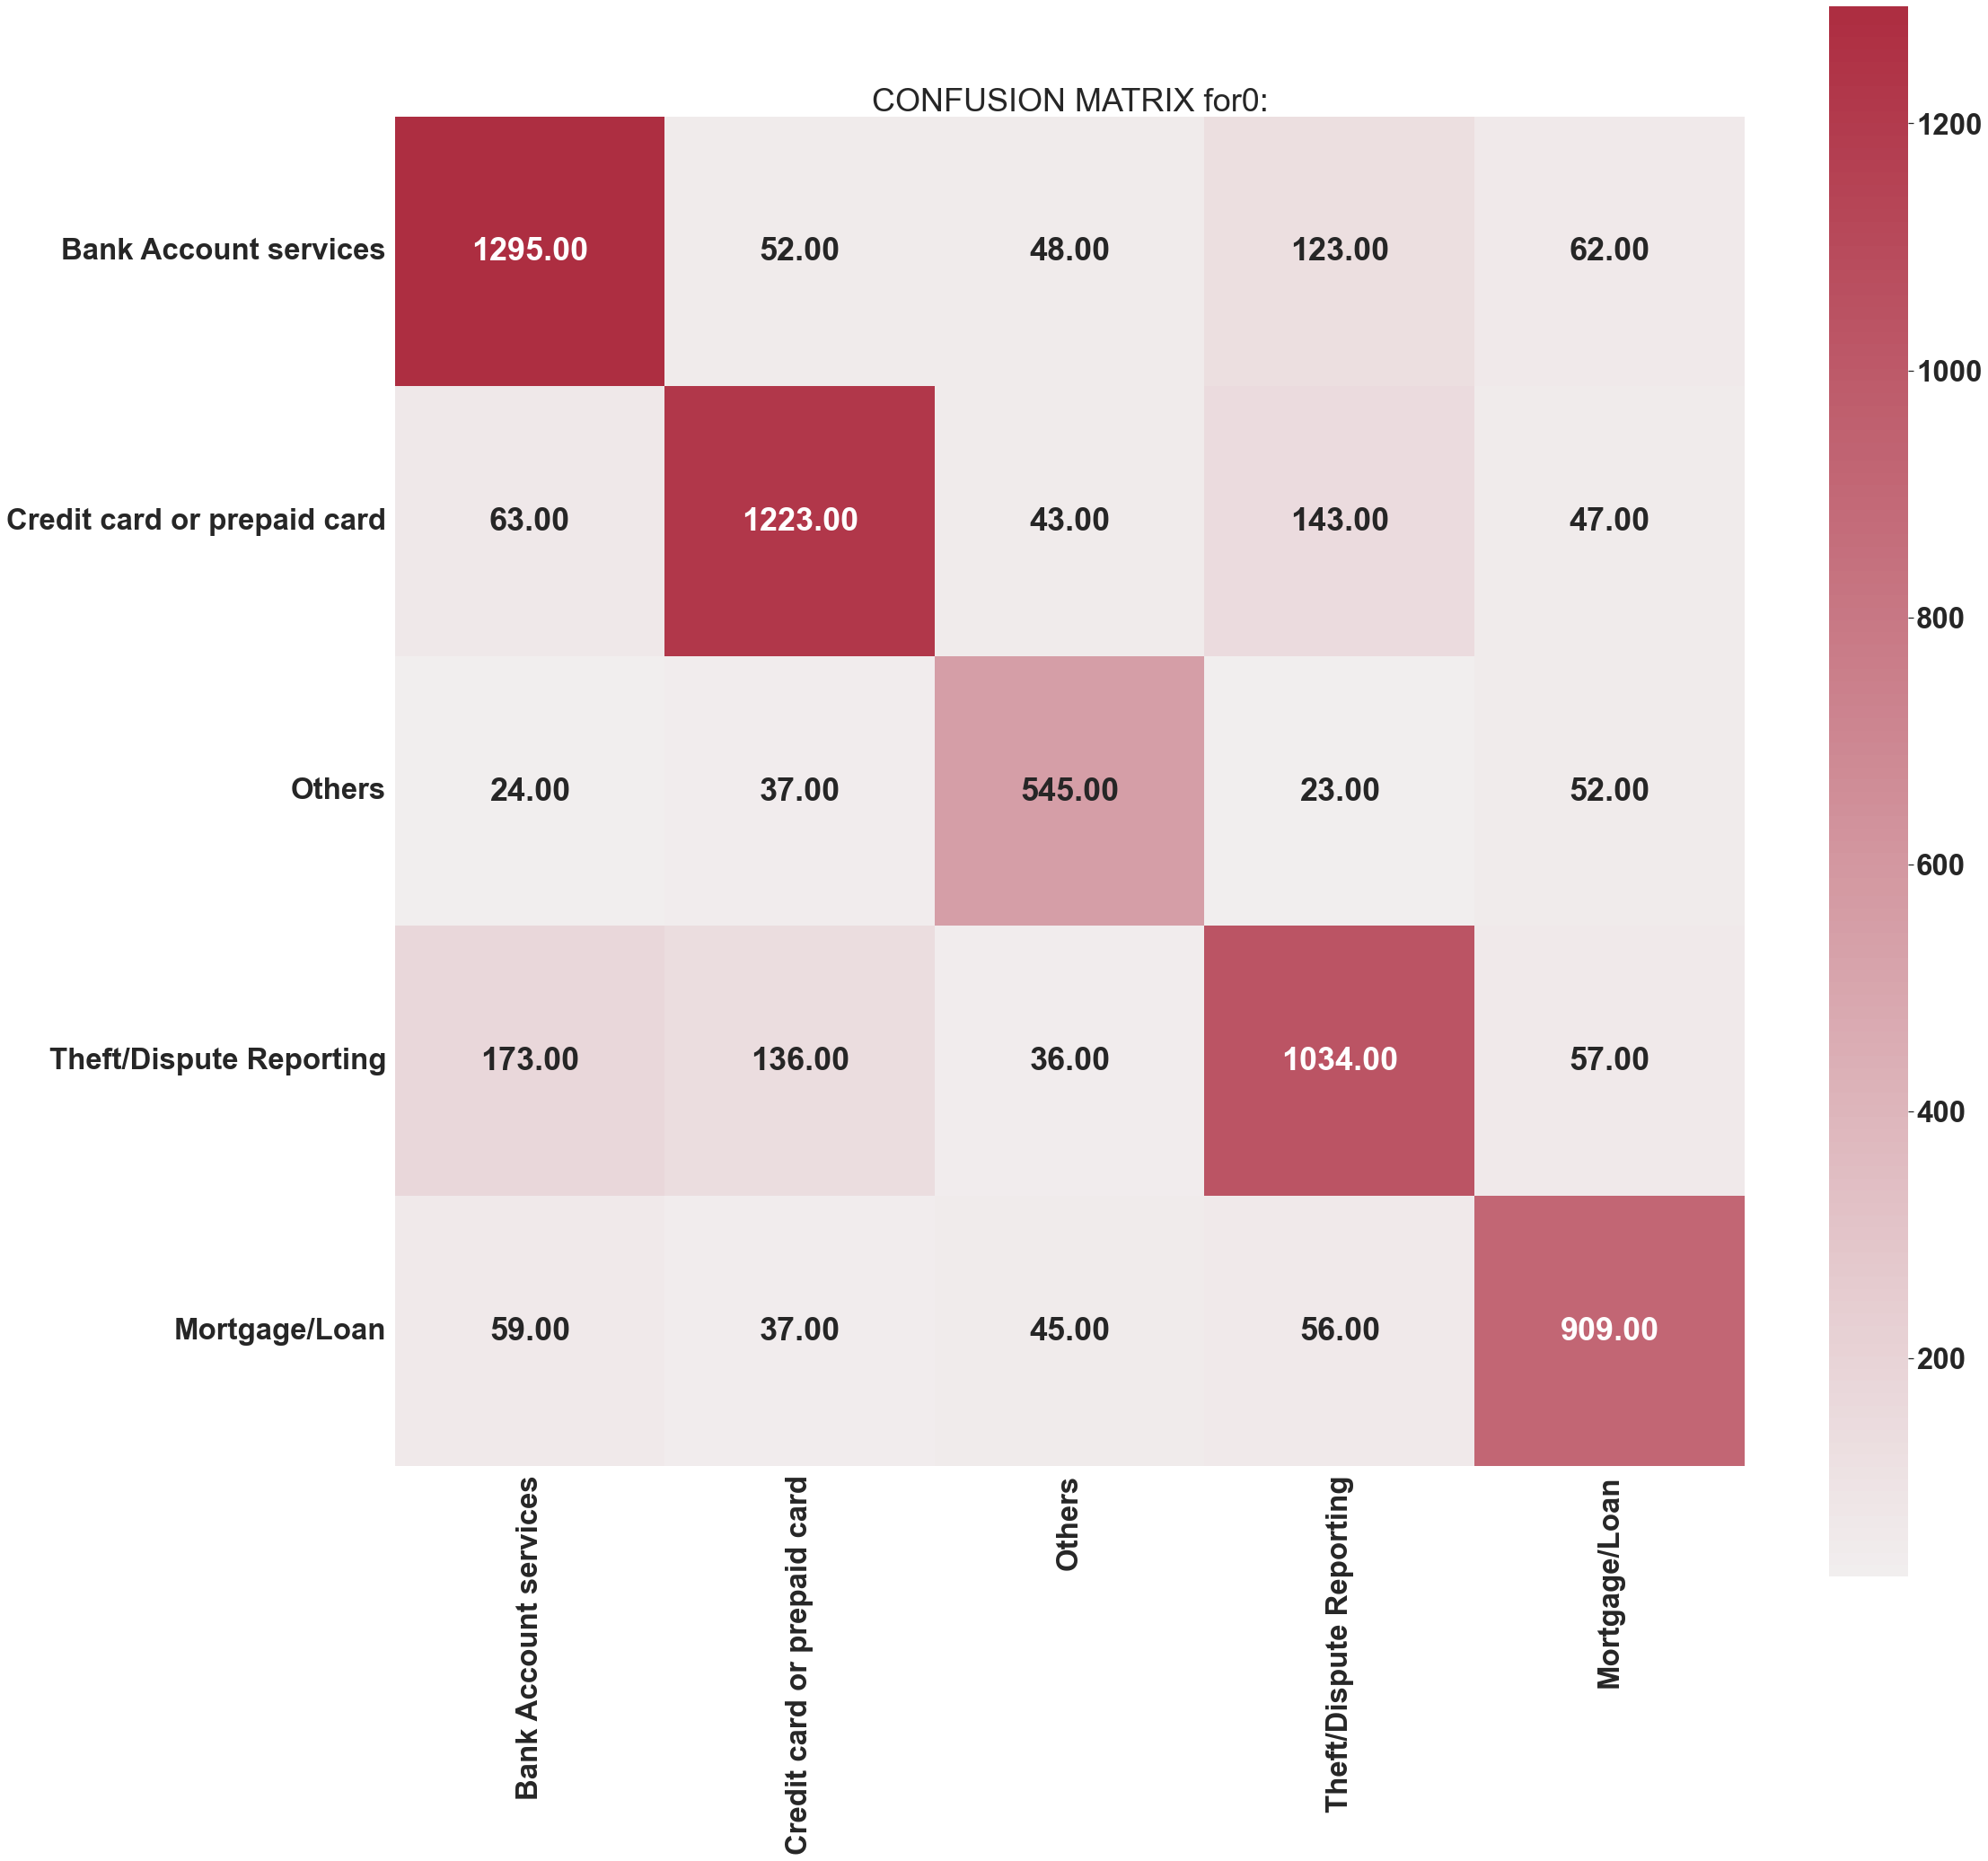

In [96]:
# Evaluate  Decision Tree classifier with best parameters
evalution_different_model(y_test, dt_tuned_y_pred, model_name)

Observation : **The F1 Score of Decision Tree model with tuned parameters gives is ~0.79**

In [97]:
f1_score_summary.loc[len(f1_score_summary.index)] = ['Decision_Tree', round(dt_f1_score_tuned, 2)]
f1_score_summary

,Model,F1_Score
0,Naive_Bayes,0.78
1,Logistic_Regression,0.94
2,Decision_Tree,0.79


### Model :4 # Random Forest

In [98]:
# Initial run of the Random Forest

model_name = 'Random Forest'
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

In [99]:
# Calculate F1 Score 
rf_f1_score = f1_score(y_test, rf_y_pred, average="weighted")
rf_f1_score

0.8190953425416635

#### Hyperparameter tuning to get best result

In [100]:
# # Hyperparameter tuning to improve Random Forest performance
rf_param = {
     'n_estimators': [100, 200, 300],
     'criterion':['gini','entropy'],
     'max_depth': [10, 30, 40],
     'min_samples_split': [1, 5, 10],
     'min_samples_leaf': [1, 5, 10],
     'max_features': ['log2', 'sqrt', None]    
 }

rf_grid = RandomizedSearchCV(estimator=rf_clf, 
                        param_distributions=rf_param,
                        scoring='f1_weighted',
                        verbose=1,
                        n_jobs=-1,
                       cv=5)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 30, 'criterion': 'entropy'}


In [101]:
# running Random Forest with best parameters 
rf_clf_tuned = RandomForestClassifier(n_estimators=300, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='entropy'
)

rf_clf_tuned.fit(X_train, y_train)
rf_tuned_y_pred = rf_clf_tuned.predict(X_test)

In [102]:
# Calculate F1 Score 
rf_f1_score_tuned = f1_score(y_test, rf_tuned_y_pred, average="weighted")
rf_f1_score_tuned

0.8480085600807471

CLASSIFICATION REPORT for Random Forest

                             precision    recall  f1-score   support

      Bank Account services       0.86      0.87      0.86      1580
Credit card or prepaid card       0.87      0.87      0.87      1519
                     Others       0.82      0.82      0.82       681
    Theft/Dispute Reporting       0.81      0.80      0.80      1436
              Mortgage/Loan       0.86      0.87      0.86      1106

                   accuracy                           0.85      6322
                  macro avg       0.85      0.85      0.85      6322
               weighted avg       0.85      0.85      0.85      6322



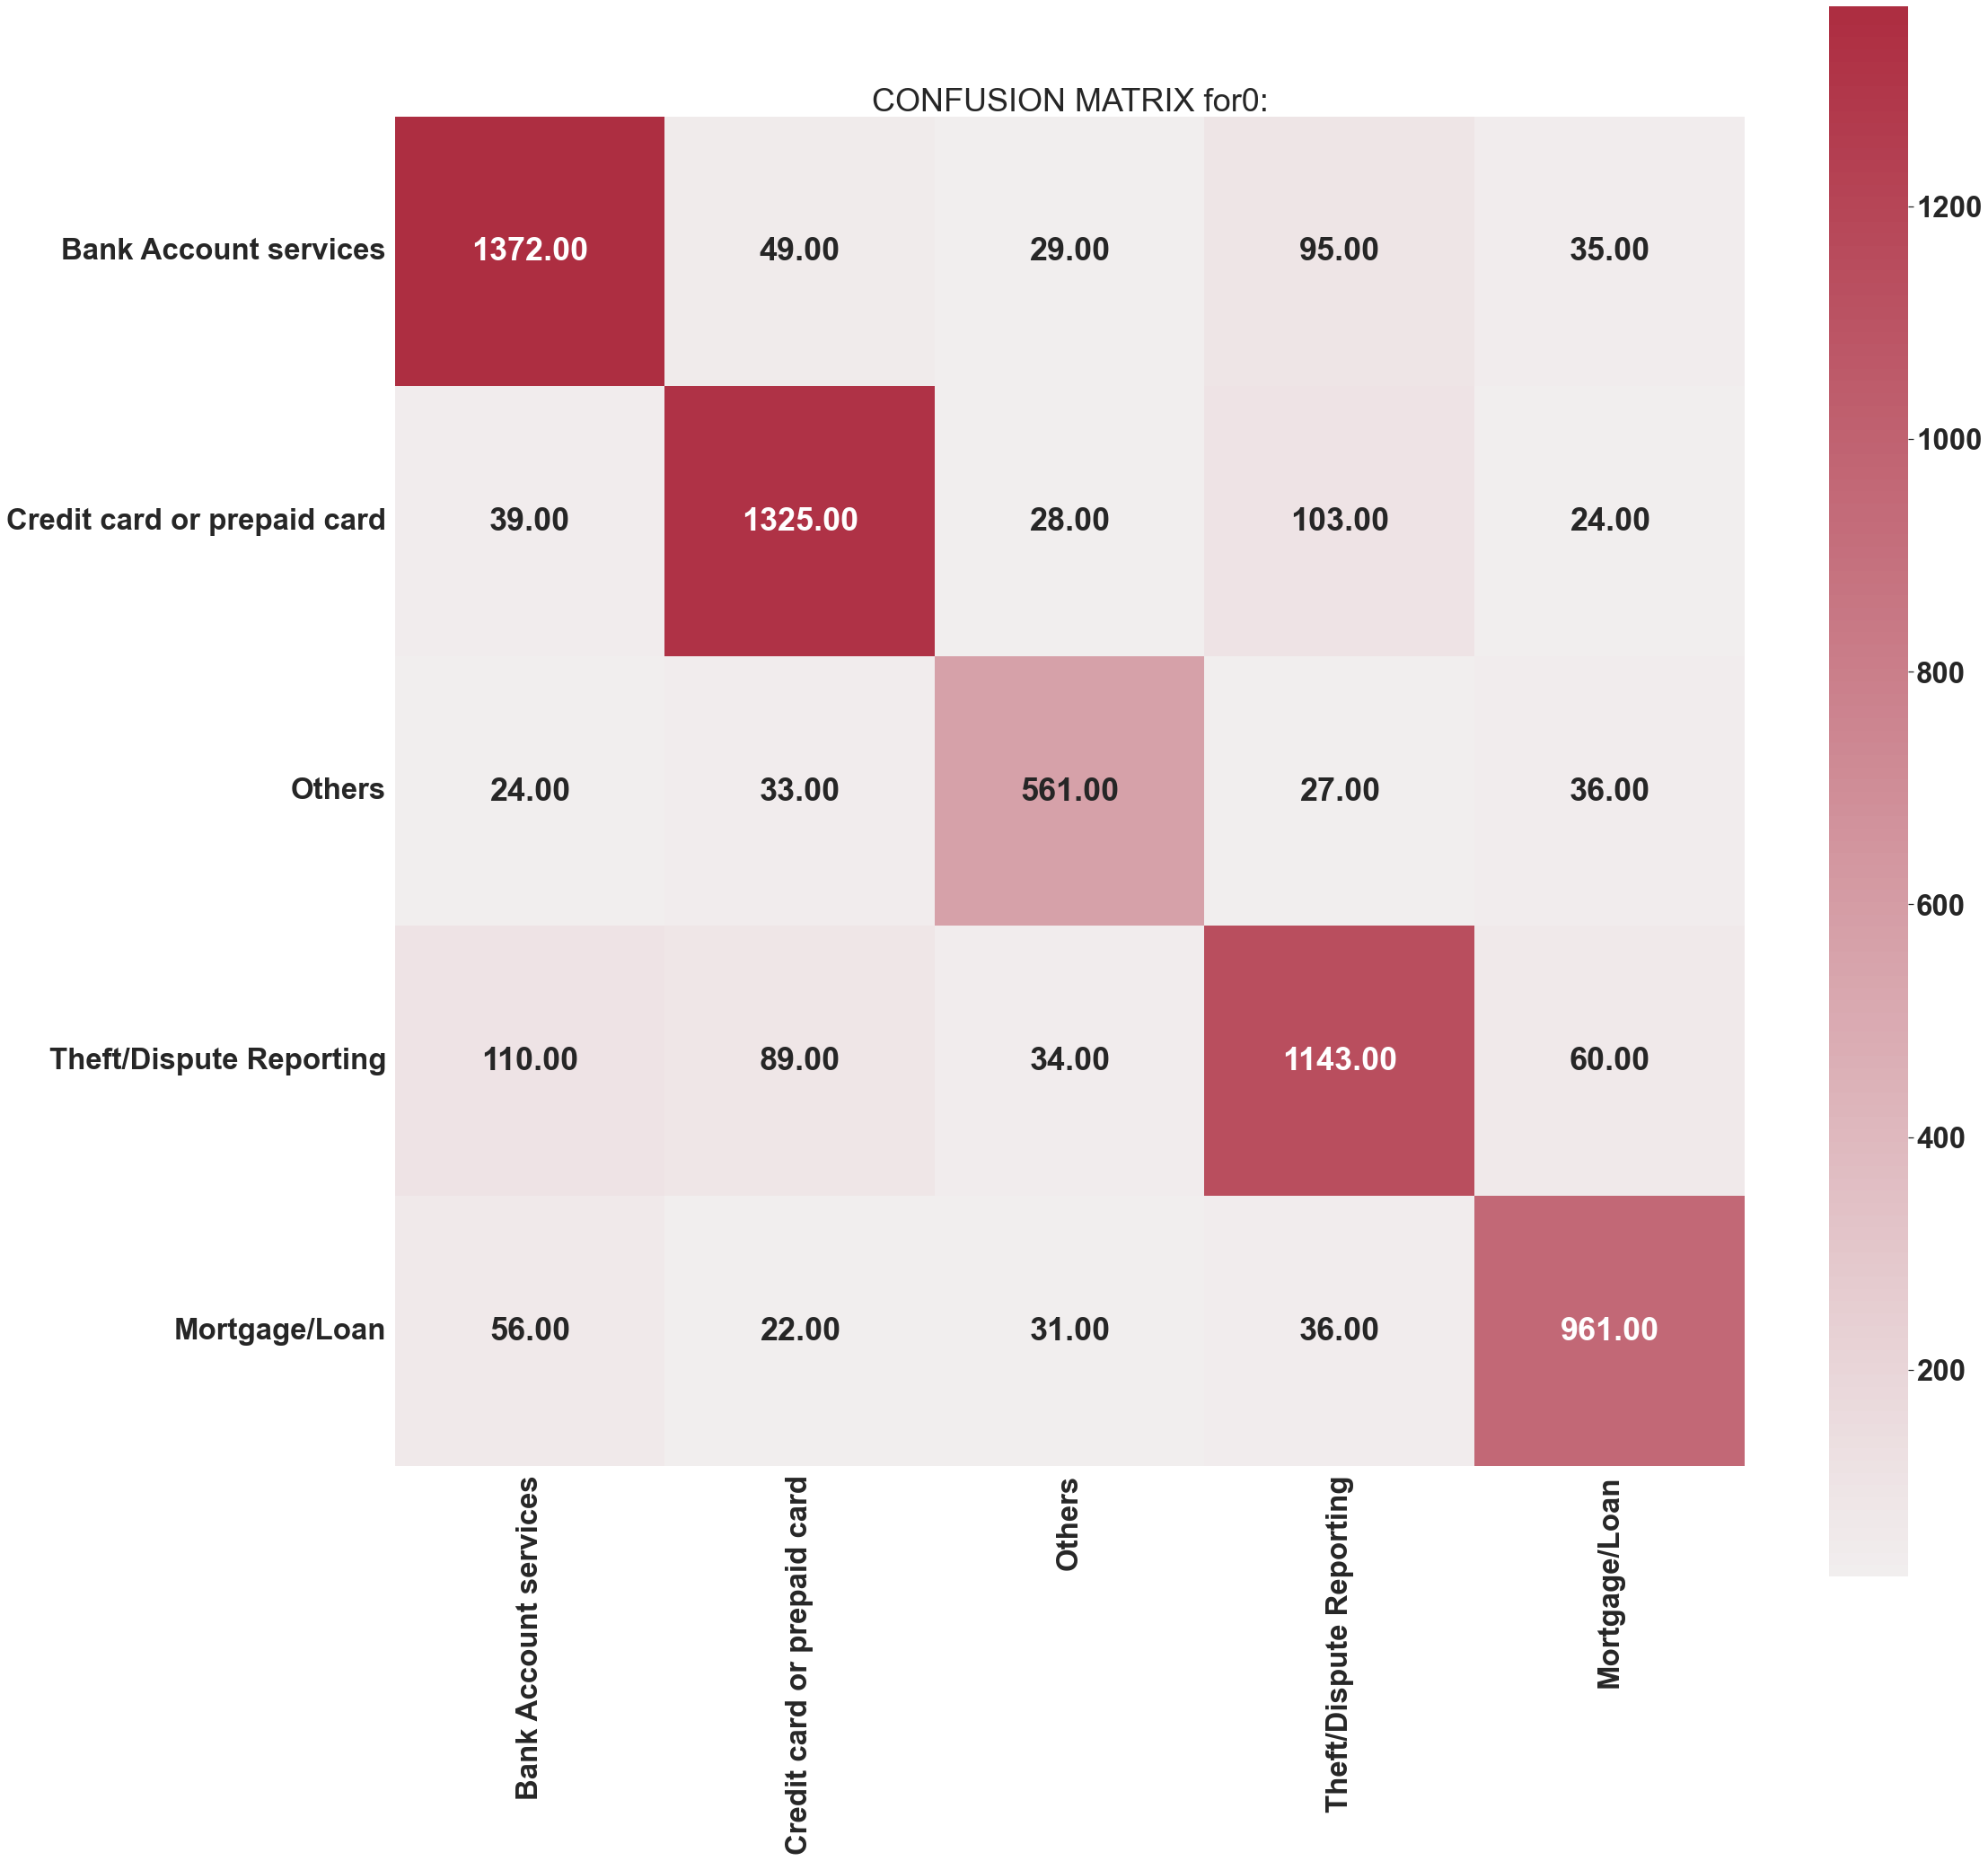

In [103]:
# Evaluate  Random Forest classifier with best parameters
evalution_different_model(y_test, rf_tuned_y_pred, model_name)

In [ ]:
f1_score_summary.loc[len(f1_score_summary.index)] = ['Random_Forest', round(rf_tuned_y_pred, 2)]
f1_score_summary

### Model :5 # XGBoost

In [104]:
# Initial run of the XG Boost

model_name = 'XGBoost'
xg_clf = XGBClassifier(tree_method='gpu_hist', 
                        gpu_id=0, 
                        predictor="gpu_predictor")
xg_clf.fit(X_train, y_train)
xg_y_pred = xg_clf.predict(X_test)

[14:45:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [105]:
# Calculate F1 Score 
xg_f1_score = f1_score(y_test, xg_y_pred, average="weighted")
xg_f1_score

0.599084269450713

#### Hyperparameter tuning to get best result

In [106]:
xg_param = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [2, 6, 10],
    'min_child_weight': [7, 11, 19],
    'scale_pos_weight': [10, 12],
    'n_estimators': [300, 500] 
}

xg_grid = RandomizedSearchCV(estimator=xg_clf, 
                       param_distributions=xg_param,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1,
                       cv=5)
xg_grid.fit(X_train, y_train)
print(xg_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:15:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'scale_pos_weight': 12, 'n_estimators': 300, 'min_child_weight': 19, 'max_depth': 2, 'learning_rate': 0.1}


In [107]:
# running Decision Tree with best parameters 

xgb_clf_tuned = XGBClassifier(scale_pos_weight=12, 
                              n_estimators=300, 
                              min_child_weight=19, 
                              max_depth=2, 
                              learning_rate=0.1, 
                              tree_method='gpu_hist', 
                              gpu_id=0, 
                              predictor="gpu_predictor"
)

xgb_clf_tuned.fit(X_train, y_train)
xgb_tuned_y_pred = xgb_clf_tuned.predict(X_test)

[15:15:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:15:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
# Calculate F1 Score 
xgb_f1_score_tuned = f1_score(y_test, xgb_tuned_y_pred, average="weighted")
xgb_f1_score_tuned

0.4478382089011409

CLASSIFICATION REPORT for XGBoost

                             precision    recall  f1-score   support

      Bank Account services       0.47      0.94      0.62      1580
Credit card or prepaid card       0.49      0.68      0.57      1519
                     Others       0.40      0.13      0.19       681
    Theft/Dispute Reporting       0.80      0.08      0.14      1436
              Mortgage/Loan       0.78      0.47      0.58      1106

                   accuracy                           0.51      6322
                  macro avg       0.59      0.46      0.42      6322
               weighted avg       0.60      0.51      0.45      6322



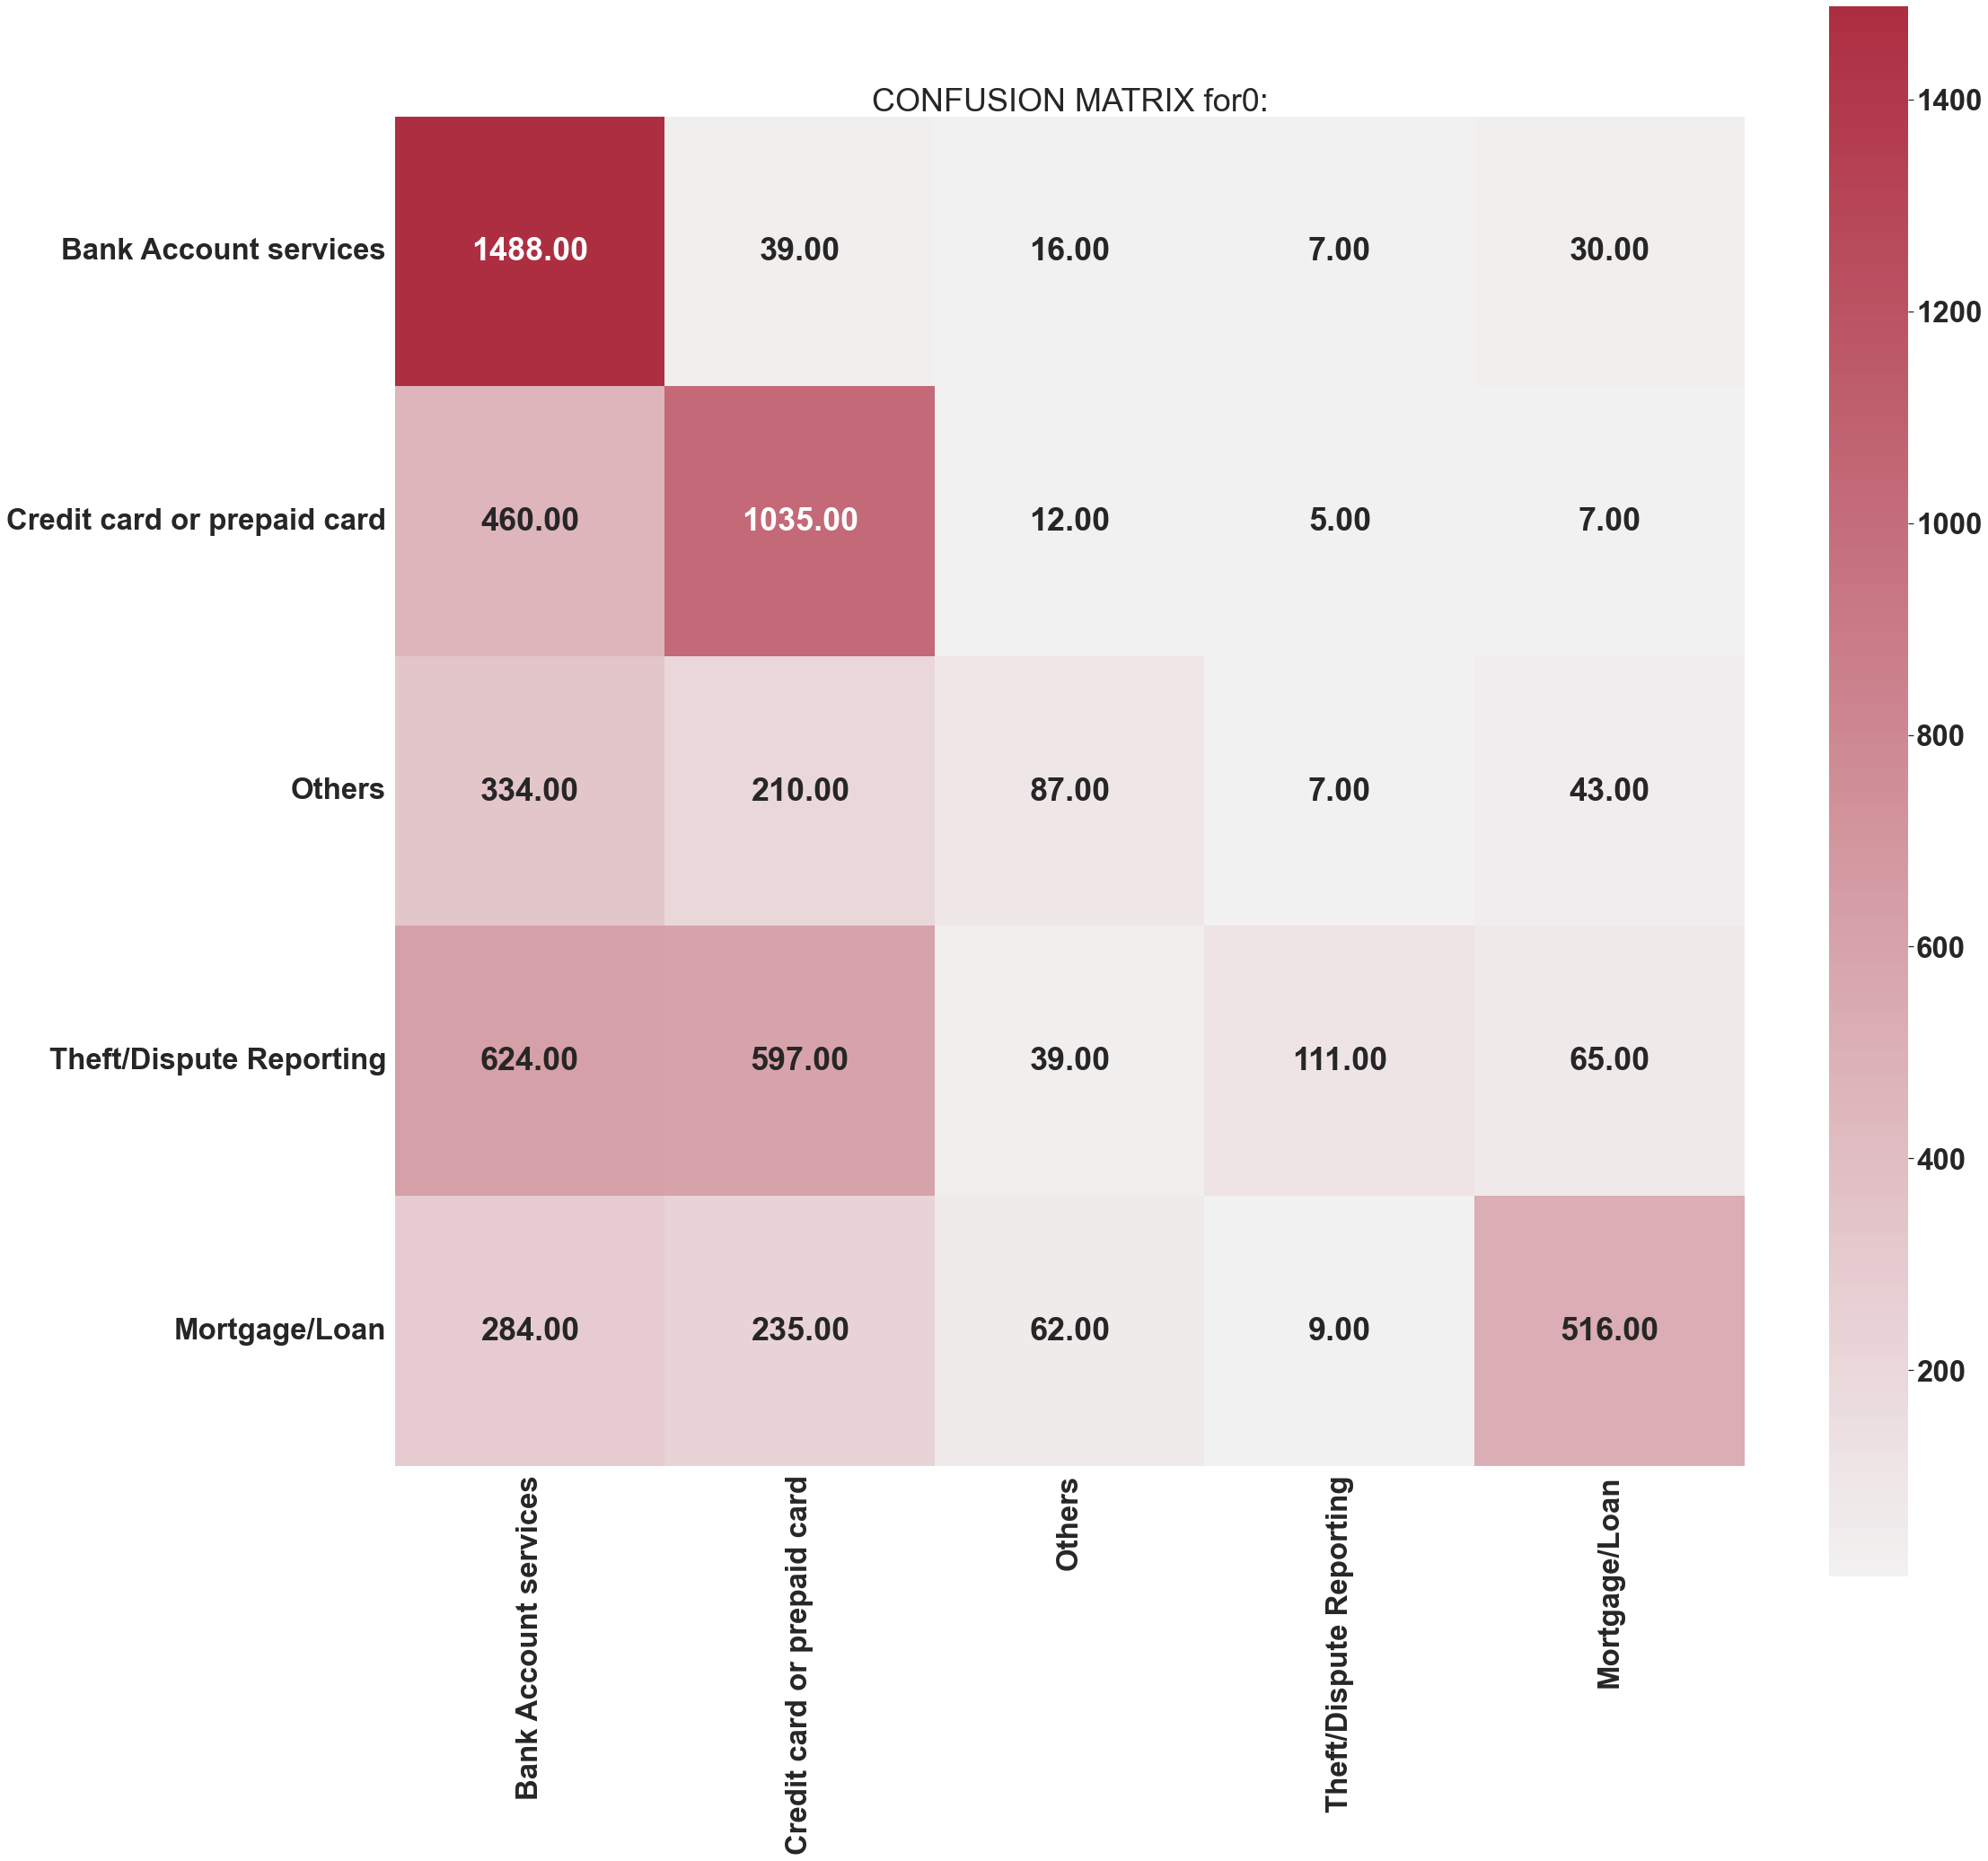

In [109]:
# Evaluate  XG BOOST  classifier with best parameters
evalution_different_model(y_test, xgb_tuned_y_pred, model_name)

In [110]:
f1_score_summary.loc[len(f1_score_summary.index)] = ['XGBOOST', round(xgb_f1_score_tuned, 2)]
f1_score_summary

,Model,F1_Score
0,Naive_Bayes,0.78
1,Logistic_Regression,0.94
2,Decision_Tree,0.79
3,XGBOOST,0.45


**INFERNCES FROM SUPERVISED MODEL TUNING**: Logistic regersssion perform better comapred to all other models

## <span style="color:Orange">Task 9: Model inference</span> 

As seen from baove model evaluations, Logistic Regeression perform better than other model hence using tuned Logistic regression model (best parameters) 

#### Predicting topic on new text data

In [113]:
# Load best parameter tuned Logistic Regression model 
pickle.dump(lr_clf_tuned, open("logreg_model.pkl", "wb"))

In [117]:
def predict_new_custom_topic(data):
    
    name_targets = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    vector_load = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    tfidf_load = pickle.load(open("tfidf.pkl","rb"))
    model_load = pickle.load(open("logreg_model.pkl","rb"))

    X_custome_count = vector_load.transform(data)
    X_custom_tfidf = tfidf_load.transform(X_custome_count)
    predict = model_load.predict(X_custom_tfidf)

    return name_targets[predict[0]]

In [118]:
# Create a dataframe of some sample customer complaints
df_lr_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_lr_new

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [119]:
# Predict new topic using Logistic regression model
df_lr_new['predicted topic'] = df_lr_new['complaints'].apply(lambda x: predict_new_custom_topic([x]))
df_lr_new

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,unwanted service activated and money deducted ...,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,Where are the bank branches in the city of Patna?,Bank Account services


## **Inference: Logistic Regression Model predict better on unknow custom new data**